우선 스프레드를 상태로 두고 예측. 이때 상태는 스칼라값. 따라서 KF에 쓰이는 모든 파라미터들(오차공분산, 측정모델, 전이모델, 측정잡음, 프로세스 잡음)도 다 스칼라(혹은 (1,) 차원의 벡터).

그 다음 성능 개선을 위해 상태벡터를 다차원으로 두고(평균으로 회귀속도, 스프레드 등으로 구성된 2, 3차원 벡터) 그러다면 다른 파라미터들도 2, 3차원 행렬/벡터로

#### 설정

In [1]:
!pip install sec_edgar_api --quiet
!pip install sec_cik_mapper --quiet
!pip install curl_cffi --quiet

In [2]:
# !pip install yfinance==0.2.54

In [3]:
# !pip show yfinance

In [4]:
from sec_edgar_api import EdgarClient
from datetime import datetime, timedelta
from sec_cik_mapper import StockMapper
from statsmodels.tsa.stattools import adfuller, kpss
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import yfinance as yf
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

import time
import datetime
from io import StringIO
from curl_cffi import requests as curl_requests

import io
import csv
import json
import requests

stock_mapper = StockMapper()

In [5]:
import torch
import torch.nn as nn

from torch.utils.data import TensorDataset, DataLoader

#### 페어 찾기

#### 야후 파이낸스 데이터 불러오기

In [6]:
start_date='2020-01-01'
end_date='2025-03-31'
ticker1='GOOG'
ticker2 = 'GOOGL'

In [7]:
session = curl_requests.Session(impersonate="chrome")
asset1 = yf.Ticker(ticker1).history(start=start_date, end=end_date)
asset2 = yf.Ticker(ticker2).history(start=start_date, end=end_date)
# hist = GOOG.history(period="5y") # stock.history(start=start_date, end=end_date)

In [8]:
asset1

,Open,High,Low,Close,Volume,Dividends,Stock Splits
Date,,,,,,,
2020-01-02 00:00:00-05:00,66.761282,68.084512,66.761282,68.046196,28132000,0.0,0.0
2020-01-03 00:00:00-05:00,67.075298,68.301492,66.960045,67.712280,23728000,0.0,0.0
2020-01-06 00:00:00-05:00,67.181792,69.495829,67.181792,69.381874,34646000,0.0,0.0
2020-01-07 00:00:00-05:00,69.567504,69.818809,69.191280,69.338585,30054000,0.0,0.0
2020-01-08 00:00:00-05:00,69.275872,70.246282,69.214168,69.884995,30560000,0.0,0.0
...,...,...,...,...,...,...,...
2025-03-24 00:00:00-04:00,169.264999,170.500000,167.440002,169.929993,18742800,0.0,0.0
2025-03-25 00:00:00-04:00,171.179993,172.910004,170.550003,172.789993,13841600,0.0,0.0
2025-03-26 00:00:00-04:00,171.300003,171.940002,166.860992,167.139999,22498000,0.0,0.0


#### 백테스팅툴

In [9]:
def pair_trading_backtest(spread_series, window, std_multiplier, initial_capital=100000, commission_rate=0.001):
  """
  Args:
    spread_series (pd.Series): 전체 스프레드 시계열 데이터.
    window (int): 이동평균 및 이동표준편차 계산을 위한 윈도우 크기.
    std_multiplier (float): 표준편차의 배수 (진입/청산 경계 설정용).
    initial_capital (float): 초기 자본금.
    commission_rate (float): 거래 수수료율 (매수/매도 시 각각 적용).

  Returns:
    pd.DataFrame: 날짜, 스프레드, 밴드, 포지션, 매매 신호, 포트폴리오 가치 등이 포함된 DataFrame.
  """
  df = pd.DataFrame(spread_series, columns=['Spread'])
  df.index.name = 'Date' # 인덱스 이름 설정

  # 지표 계산 (전체 기간에 대해)
  df['Mean'] = df['Spread'].rolling(window=window, min_periods=1).mean()
  df['StdDev'] = df['Spread'].rolling(window=window, min_periods=1).std()
  df['UpperBand'] = df['Mean'] + std_multiplier * df['StdDev']
  df['LowerBand'] = df['Mean'] - std_multiplier * df['StdDev']

  # 포지션 및 신호 생성
  df['Position'] = 0  # +1: Long Spread, -1: Short Spread, 0: No Position
  # Position은 상태이므로, 이전 상태를 알아야 함.
  for i in range(len(df)):
    # 통계치가 없는 초기 구간은 건너뜀
    if i < window -1 :
      df.loc[df.index[i], 'Position'] = 0 # 초기엔 무포지션 또는 이전 포지션 유지(여기선 무포지션으로 시작)
      continue

    current_spread = df['Spread'].iloc[i]
    upper_band = df['UpperBand'].iloc[i]
    lower_band = df['LowerBand'].iloc[i]
    prev_position = df['Position'].iloc[i-1] if i > 0 else 0

    if pd.isna(upper_band) or pd.isna(lower_band): # 데이터 부족으로 밴드 계산 안될 시
      df.loc[df.index[i], 'Position'] = prev_position
      continue

    # 매매 규칙 적용
    if current_spread > upper_band:
      df.loc[df.index[i], 'Position'] = -1 # 스프레드 매도
    elif current_spread < lower_band:
      df.loc[df.index[i], 'Position'] = 1  # 스프레드 매수
    else: # 밴드 내부
      # 평균으로 회귀하면 청산하는 로직 (선택적)
      # if prev_position == 1 and current_spread >= df['Mean'].iloc[i]:
      #     df.loc[df.index[i], 'Position'] = 0 # 롱 포지션 청산
      # elif prev_position == -1 and current_spread <= df['Mean'].iloc[i]:
      #     df.loc[df.index[i], 'Position'] = 0 # 숏 포지션 청산
      # else:
      #     df.loc[df.index[i], 'Position'] = prev_position # 포지션 유지

      # 여기서는 밴드 내에서는 이전 포지션 유지 (밴드 이탈 시에만 포지션 변경)
      df.loc[df.index[i], 'Position'] = prev_position


  # 실제 거래 신호 (포지션 변경 시점)
  df['Signal'] = df['Position'].diff().fillna(0)

  # 수익률 계산
  # 스프레드 변화분 * 이전 시점의 포지션
  # Position이 +1 (롱) 이면 스프레드 상승 시 이익
  # Position이 -1 (숏) 이면 스프레드 하락 시 이익 (스프레드 변화분 * -1 이므로)
  df['StrategyReturns_Raw'] = df['Spread'].diff() * df['Position'].shift(1)
  df['StrategyReturns_Raw'].fillna(0, inplace=True)

  # 거래 비용 반영
  trades = df['Signal'][df['Signal'] != 0].index
  transaction_costs = 0
  # 간단하게, 거래 발생 시 스프레드 값의 일정 비율을 비용으로 차감
  # 더 정확하게 하려면 매수/매도하는 각 자산의 가격과 수량을 알아야 하지만,
  # 여기서는 스프레드 자체를 거래한다고 가정하고, 스프레드 값의 비율로 비용을 계산
  # 또는, 거래 횟수당 고정 비용을 둘 수도 있음
  # 여기서는 스프레드 값의 비율로 수수료를 부과 (단순화)
  # 실제로는 스프레드 거래 시 두 자산에 대한 거래 비용이 발생함.
  # 여기서는 'Signal' 발생 시 'Spread' 값에 commission_rate를 곱한 값을 비용으로 가정.
  # 비용은 수익률에서 차감.

  df['TransactionCost'] = 0.0
  # 포지션 진입/청산 시점에만 비용 발생
  # df.loc[df['Signal'] != 0, 'TransactionCost'] = np.abs(df['Spread']) * commission_rate # 이렇게 하면 스프레드 크기에 따라 비용 달라짐
  # 또는, 더 간단히, 거래 1회당 수익률에서 고정 비율 차감
  # 아래는 거래가 일어날 때마다 'StrategyReturns_Raw'에서 commission_rate 만큼 차감하는 방식 (수익률 자체에서 비율 차감)
  # 이는 initial_capital 대비 비용이므로, 스프레드 거래의 레버리지 등을 고려하면 더 복잡해짐.

  # 여기서는 수익률에 대한 비율로 가정: 수익률이 발생했을 때 그 수익률의 %를 비용으로
  # (매우 단순화된 접근, 실제 자산 가격 기반 비용 계산이 더 정확)
  # df['StrategyReturns'] = df['StrategyReturns_Raw']
  # df.loc[df['Signal'] != 0, 'StrategyReturns'] -= np.abs(df['StrategyReturns_Raw']) * commission_rate

  # 더 직관적인 방법: 매매가 발생할 때, '스프레드 가격'의 % 만큼을 비용으로.
  # 이는 실제 포트폴리오 가치에 직접 영향을 줌.
  # 이 함수에서는 포트폴리오 가치를 직접 시뮬레이션하면서 비용을 차감하는 것이 더 명확함.

  # 포트폴리오 가치 시뮬레이션
  df['Cash'] = 0.0
  df['Holdings_Spread_Units'] = 0.0 # 스프레드 보유 단위 (예: 1단위)
  df['PortfolioValue'] = initial_capital
  df['Commission'] = 0.0

  df.loc[df.index[0], 'Cash'] = initial_capital

  for i in range(1, len(df)):
    # 이전 값 복사
    df.loc[df.index[i], 'Cash'] = df['Cash'].iloc[i-1]
    df.loc[df.index[i], 'Holdings_Spread_Units'] = df['Holdings_Spread_Units'].iloc[i-1]

    signal = df['Signal'].iloc[i]
    current_spread_price = df['Spread'].iloc[i] # 현재 스프레드 가격

    commission_this_trade = 0

    if signal != 0: # 거래 발생
      # 기존 포지션 청산 (비용 발생)
      if df['Holdings_Spread_Units'].iloc[i-1] != 0:
        # 청산 시 스프레드 가격 * 보유 단위 * 수수료 (단순화)
        # 실제로는 두 자산 각각에 대한 거래 비용
        commission_this_trade += np.abs(df['Holdings_Spread_Units'].iloc[i-1] * current_spread_price) * commission_rate
        df.loc[df.index[i], 'Cash'] -= commission_this_trade

      # 새 포지션 진입 (비용 발생)
      if df['Position'].iloc[i] != 0:
        # 진입 시 스프레드 가격 * 새 포지션 단위 * 수수료
        # 여기서 '단위'는 1로 가정. 자본금에 따라 조절 가능.
        # 여기서는 단순화를 위해 포지션이 1 또는 -1 일 때, 1 단위의 스프레드를 거래한다고 가정.
        # 이 '단위'를 자본금에 비례하도록 설정할 수도 있음. (예: capital_per_trade / current_spread_price)
        # 지금은 포지션 값 자체를 단위로 사용.

        # 진입 시 거래량 결정 (예: 가용 현금의 일부를 사용하거나, 고정 단위)
        # 여기서는 단순하게 Position을 단위로 사용하지 않고, 1 단위로 고정.
        # Position 값은 방향만 지시.
        units_to_trade = df['Position'].iloc[i] # 이게 1 또는 -1

        # 실제로는 자본금에 따라 거래 단위를 정해야 함.
        # 예: trade_amount = df['Cash'].iloc[i-1] * 0.1 # 가용 현금의 10%
        # units_to_trade_dynamic = trade_amount / current_spread_price if current_spread_price != 0 else 0
        # df.loc[df.index[i], 'Holdings_Spread_Units'] = units_to_trade_dynamic * df['Position'].iloc[i] # 방향 적용

        # 여기서는 매우 단순하게 Position 값 자체를 보유 단위로 간주.
        df.loc[df.index[i], 'Holdings_Spread_Units'] = df['Position'].iloc[i]

        # 새 포지션 진입 비용
        commission_for_new_pos = np.abs(df['Holdings_Spread_Units'].iloc[i] * current_spread_price) * commission_rate
        commission_this_trade += commission_for_new_pos
        df.loc[df.index[i], 'Cash'] -= commission_for_new_pos

    df.loc[df.index[i], 'Commission'] = commission_this_trade

    # 포트폴리오 가치 업데이트
    # (보유 스프레드 가치 변화 + 현금)
    # 보유 스프레드의 가치 = 보유 단위 * 현재 스프레드 가격
    holdings_value = df['Holdings_Spread_Units'].iloc[i] * current_spread_price
    # 전일 대비 보유 스프레드 가치 변화분
    # prev_holdings_value = df['Holdings_Spread_Units'].iloc[i-1] * df['Spread'].iloc[i-1]
    # pnl_from_holdings = holdings_value - prev_holdings_value (이건 좀 복잡해짐)

    # 더 간단한 방법:
    # 전일 포트폴리오 가치 + (오늘의 스프레드 변화 * 전일 보유 단위) - 오늘 발생한 수수료
    daily_pnl_raw = (df['Spread'].iloc[i] - df['Spread'].iloc[i-1]) * df['Holdings_Spread_Units'].iloc[i-1] # 전일 포지션 기준
    df.loc[df.index[i], 'PortfolioValue'] = df['PortfolioValue'].iloc[i-1] + daily_pnl_raw - df['Commission'].iloc[i]

  df['StrategyReturns'] = df['PortfolioValue'].pct_change().fillna(0)
  df['CumulativeStrategyReturns'] = (1 + df['StrategyReturns']).cumprod() -1

  return df

In [10]:
def calculate_performance_metrics(portfolio_df, initial_capital):
  """포트폴리오 성과 지표를 계산합니다."""
  final_value = portfolio_df['PortfolioValue'].iloc[-1]
  total_return_pct = (final_value / initial_capital - 1) * 100

  days = (portfolio_df.index[-1] - portfolio_df.index[0]).days
  if days == 0:
    cagr = 0
  else:
    # 영업일 기준으로 연율화 (보통 252일)
    num_trading_days_in_year = 252
    num_years = len(portfolio_df) / num_trading_days_in_year # 실제 거래일수 기준
    if num_years == 0: num_years = 1 # 데이터가 너무 짧을 경우
    cagr = ((final_value / initial_capital) ** (1 / num_years) - 1) * 100 if num_years > 0 else 0


  # 최대 낙폭 (MDD)
  portfolio_df['PeakValue'] = portfolio_df['PortfolioValue'].cummax()
  portfolio_df['Drawdown'] = (portfolio_df['PortfolioValue'] - portfolio_df['PeakValue']) / portfolio_df['PeakValue']
  max_drawdown_pct = portfolio_df['Drawdown'].min() * 100

  # 샤프 지수 (일간 수익률 사용, 무위험 이자율 0% 가정)
  daily_returns = portfolio_df['StrategyReturns']
  if daily_returns.std() == 0:
    sharpe_ratio = 0
  else:
    # 연율화 (거래일 기준)
    sharpe_ratio = daily_returns.mean() / daily_returns.std() * np.sqrt(num_trading_days_in_year)

  num_trades = len(portfolio_df[portfolio_df['Signal'] != 0])

  print(f"\n--- 백테스팅 성과 ({portfolio_df.index[0].date()} ~ {portfolio_df.index[-1].date()}) ---")
  print(f"초기 자본: {initial_capital:,.0f}")
  print(f"최종 자산: {final_value:,.2f}")
  print(f"총 수익률: {total_return_pct:.2f}%")
  print(f"CAGR (연평균 수익률): {cagr:.2f}%")
  print(f"최대 낙폭 (MDD): {max_drawdown_pct:.2f}%")
  print(f"샤프 지수 (연율화): {sharpe_ratio:.2f}")
  print(f"총 거래 횟수: {num_trades}")

  return {
    "total_return_pct": total_return_pct,
    "cagr": cagr,
    "max_drawdown_pct": max_drawdown_pct,
    "sharpe_ratio": sharpe_ratio,
    "final_value": final_value,
    "num_trades": num_trades
  }

In [49]:
def run_and_visualize_backtest(spread_series, rolling_window, std_dev_multiplier, initial_capital, commission_rate):
  """
  전략 파라미터를 사용하여 백테스팅을 실행하고 결과를 시각화합니다.

  Args:
    spread_series (pd.Series): 전체 스프레드 시계열 데이터.
    rolling_window (int): 이동평균 및 이동표준편차 계산을 위한 윈도우 크기.
    std_dev_multiplier (float): 표준편차의 배수 (진입/청산 경계 설정용).
    initial_capital (float): 초기 자본금.
    commission_rate (float): 거래 수수료율.

  Returns:
    tuple: (results_df, performance_metrics)
            results_df (pd.DataFrame): 백테스팅 결과 상세 DataFrame.
            performance_metrics (dict): 계산된 성과 지표.
  """
  # 백테스팅 실행
  results_df = pair_trading_backtest(spread_series, window=rolling_window, std_multiplier=std_dev_multiplier, initial_capital=initial_capital, commission_rate=commission_rate)

  # 성과 분석
  performance_metrics = calculate_performance_metrics(results_df, initial_capital)

  # 시각화
  data_length = len(spread_series) # 시각화 제목용
  fig, axes = plt.subplots(3, 1, figsize=(15, 12), sharex=True)
  plt.style.use('seaborn-v0_8-whitegrid')

  # 차트 1: 스프레드 및 밴드, 매매 신호
  ax1 = axes[0]
  ax1.plot(results_df.index, results_df['Spread'], label='Spread', color='dodgerblue', lw=1.5)
  ax1.plot(results_df.index, results_df['Mean'], label=f'{rolling_window}-Day Mean', color='orange', linestyle='--', lw=1.5)
  ax1.plot(results_df.index, results_df['UpperBand'], label=f'Upper Band (+{std_dev_multiplier}σ)', color='red', linestyle=':', lw=1.5)
  ax1.plot(results_df.index, results_df['LowerBand'], label=f'Lower Band (-{std_dev_multiplier}σ)', color='green', linestyle=':', lw=1.5)

  buy_signals = results_df[results_df['Signal'] > 0]
  sell_signals = results_df[results_df['Signal'] < 0]

  ax1.plot(buy_signals.index, results_df.loc[buy_signals.index, 'Spread'], '^', markersize=8, color='lime', label='Buy Signal Action', markeredgecolor='black')
  ax1.plot(sell_signals.index, results_df.loc[sell_signals.index, 'Spread'], 'v', markersize=8, color='tomato', label='Sell Signal Action', markeredgecolor='black')

  ax1.set_title(f'Spread, Trading Bands, and Signals (Full {data_length} Days)')
  ax1.set_ylabel('Spread Value')
  ax1.legend(loc='upper left')
  ax1.grid(True, linestyle=':', alpha=0.7)

  # 차트 2: 포지션
  ax2 = axes[1]
  ax2.plot(results_df.index, results_df['Position'], label='Position', color='purple', marker='.', linestyle='-', drawstyle='steps-post', lw=1.5)
  ax2.set_title('Trading Position')
  ax2.set_ylabel('Position (+1: Long, -1: Short, 0: Neutral)')
  ax2.set_yticks([-1, 0, 1])
  ax2.legend(loc='upper left')
  ax2.grid(True, linestyle=':', alpha=0.7)

  # 차트 3: 포트폴리오 가치
  ax3 = axes[2]
  ax3.plot(results_df.index, results_df['PortfolioValue'], label='Portfolio Value', color='forestgreen', lw=1.5)
  ax3.set_title('Portfolio Value Over Time')
  ax3.set_ylabel('Portfolio Value ($)')
  ax3.legend(loc='upper left')
  ax3.grid(True, linestyle=':', alpha=0.7)

  # # 누적 수익률을 두 번째 Y축에 표시 (선택적)
  # ax3b = ax3.twinx()
  # ax3b.plot(results_df.index, results_df['CumulativeStrategyReturns'] * 100, label='Cumulative Returns (%)', color='teal', linestyle='--', lw=1.5)
  # ax3b.set_ylabel('Cumulative Returns (%)')
  # ax3b.legend(loc='lower right')


  plt.xlabel('Date')
  plt.tight_layout()
  plt.show()

  # print("\n--- 백테스팅 결과 상세 (마지막 5일) ---")
  # print(results_df[['Spread', 'Mean', 'Position', 'Signal', 'Commission', 'PortfolioValue', 'StrategyReturns']].tail())

  return results_df, performance_metrics

## New Ver

#### LSTM-KF 모델 준비

데이터 바꿔보기, 오차 실제로 어느 정도인지 확인, batch 수정

In [11]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class HybridLSTMKalman(nn.Module):
  def __init__(self, hidden_dim=16):
    super().__init__()
    # LSTMCell: input_size=1 (scalar), hidden_size=hidden_dim
    self.lstm_f = nn.LSTMCell(input_size=1, hidden_size=hidden_dim)
    self.lstm_q = nn.LSTMCell(input_size=1, hidden_size=hidden_dim)
    self.lstm_r = nn.LSTMCell(input_size=1, hidden_size=hidden_dim)
    # map hidden state → scalar F, Q, R
    self.fc_f = nn.Linear(hidden_dim, 1)
    self.fc_q = nn.Linear(hidden_dim, 1)
    self.fc_r = nn.Linear(hidden_dim, 1)
    # to ensure Q, R >= 0
    self.softplus = nn.Softplus()

  def forward(self, y_seq, x0=None, P0=None):
    """
    y_seq: tensor of shape (batch, seq_len), 관측 스프레드
    x0:     initial state estimate, tensor (batch,) or None → zeros
    P0:     initial error covariance, tensor (batch,) or None → ones
    returns: x_preds: tensor (batch, seq_len) = 업데이트된 상태 추정값
    """
    batch, seq_len = y_seq.shape
    device = y_seq.device

    # 초기값 설정
    if x0 is None:
      x_prev = torch.zeros(batch, device=device)
    else:
      x_prev = x0.view(batch).to(device)
    if P0 is None:
      P_prev = torch.ones(batch, device=device)
    else:
      P_prev = P0.view(batch).to(device)

    # LSTM hidden/cell 초기화
    h_f = c_f = torch.zeros(batch, self.lstm_f.hidden_size, device=device)
    h_q = c_q = torch.zeros(batch, self.lstm_q.hidden_size, device=device)
    h_r = c_r = torch.zeros(batch, self.lstm_r.hidden_size, device=device)

    x_preds = []

    # 이전 관측값(y_prev): t=0일 때 y_prev=y_seq[:,0]
    y_prev = y_seq[:, 0]

    for t in range(seq_len):
      # 1) LSTMCell에 입력
      # f, q는 이전 상태 추정값(x_prev)을, r은 이전 관측값(y_prev)을 input으로 사용
      inp_f = x_prev.unsqueeze(1)           # (batch,1)
      inp_q = x_prev.unsqueeze(1)
      inp_r = y_prev.unsqueeze(1)

      h_f, c_f = self.lstm_f(inp_f, (h_f, c_f))
      h_q, c_q = self.lstm_q(inp_q, (h_q, c_q))
      h_r, c_r = self.lstm_r(inp_r, (h_r, c_r))

      # 2) scalar F_t, Q_t, R_t 생성
      F_t = self.fc_f(h_f).view(batch)      # (batch,)
      Q_t = self.softplus(self.fc_q(h_q)).view(batch)
      R_t = self.softplus(self.fc_r(h_r)).view(batch)

      # 3) Kalman predict
      x_pred = F_t * x_prev
      P_pred = F_t * P_prev * F_t + Q_t

      # 4) Kalman update (H=1)
      y_t = y_seq[:, t]
      K_t = P_pred / (P_pred + R_t + 1e-6)  # 칼만 이득
      x_upd = x_pred + K_t * (y_t - x_pred)
      P_upd = (1 - K_t) * P_pred

      # 5) 다음 스텝을 위해 상태 저장
      x_preds.append(x_upd)
      x_prev = x_upd
      P_prev = P_upd
      y_prev = y_t

    # (seq_len, batch) → (batch, seq_len)
    x_preds = torch.stack(x_preds, dim=1)
    return x_preds

#### 데이터 준비

In [12]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
import numpy as np
import pandas as pd # 데이터 준비용
from sklearn.preprocessing import MinMaxScaler # 데이터 준비용

# ==============================================================================
# 2. 데이터 준비
# ==============================================================================
ticker_a = 'GOOGL'
ticker_c = 'GOOG'
df = pd.DataFrame({ticker_a: asset1['Close'], ticker_c: asset2['Close']})
df.ffill(inplace=True)
df.bfill(inplace=True) # 혹시 모를 시작 부분 결측치도 이전 값으로 채움 (ffill 후 bfill)
df.dropna(inplace=True) # 그래도 남은 결측치 제거 (데이터가 충분하지 않을 경우)

if df.empty:
  raise ValueError("데이터를 불러오지 못했거나 데이터가 비어있습니다. 티커와 날짜를 확인하세요.")

df['Spread'] = df[ticker_a] - df[ticker_c]
spread_values = df['Spread'].values.astype(np.float32) # Numpy 배열로 변환

def create_input_sequences(data, seq_len):
  """모델 입력 y_seq (관측 시퀀스)를 생성. (num_samples, seq_len) 형태"""
  sequences = []
  if len(data) <= seq_len:
    return np.array(sequences)
  for i in range(len(data) - seq_len + 1): # 수정: 모든 가능한 시퀀스 포함
    seq = data[i : i + seq_len] # 슬라이딩 윈도우 방식으로 하나의 샘플에 20일치의 데이터가 담김. 모두 다 시간 순서대로 들어감.
    sequences.append(seq) # n번 샘플은 n-1번 이후의 순서에 맞는 애들로 들어가게됨
  return np.array(sequences)

SEQ_LEN_MODEL = 20 # 모델이 한 번에 처리할 시퀀스 길이
observed_spread_sequences = create_input_sequences(spread_values, SEQ_LEN_MODEL)

if observed_spread_sequences.shape[0] == 0:
  raise ValueError(f"시퀀스 생성 후 데이터가 없습니다. 데이터 기간이나 SEQ_LEN_MODEL({SEQ_LEN_MODEL})을 확인하세요.")

print(f"생성된 관측 시퀀스 (y_seq) 형태: {observed_spread_sequences.shape}") # (N, SEQ_LEN_MODEL)

# --- 데이터 분할 ---
total_samples = observed_spread_sequences.shape[0]
train_ratio = 0.7
val_ratio = 0.15
train_size = int(total_samples * train_ratio)
val_size = int(total_samples * val_ratio)

y_seq_train = observed_spread_sequences[:train_size]
y_seq_val = observed_spread_sequences[train_size : train_size + val_size]
y_seq_test = observed_spread_sequences[train_size + val_size :]

print(f"훈련 데이터 (y_seq_train) 형태: {y_seq_train.shape}")
print(f"검증 데이터 (y_seq_val) 형태: {y_seq_val.shape}")
print(f"테스트 데이터 (y_seq_test) 형태: {y_seq_test.shape}")

# 정규화
# Scaler는 훈련 데이터에만 fit
scaler = MinMaxScaler(feature_range=(-1, 1))
y_seq_train_reshaped = y_seq_train.reshape(-1, 1) # (N*seq_len, 1) 형태로 만들어 fit
scaler.fit(y_seq_train_reshaped)

y_seq_train_scaled = scaler.transform(y_seq_train_reshaped).reshape(y_seq_train.shape)
y_seq_val_scaled = scaler.transform(y_seq_val.reshape(-1, 1)).reshape(y_seq_val.shape)
y_seq_test_scaled = scaler.transform(y_seq_test.reshape(-1, 1)).reshape(y_seq_test.shape)

# DataLoader 준비
BATCH_SIZE_DL = 32

# 훈련 시 입력은 y_seq_scaled, 타겟도 y_seq_scaled (모델 출력 x_preds와 비교)
train_dataset_model = TensorDataset(torch.tensor(y_seq_train_scaled, dtype=torch.float32))
val_dataset_model = TensorDataset(torch.tensor(y_seq_val_scaled, dtype=torch.float32))
test_dataset_model = TensorDataset(torch.tensor(y_seq_test_scaled, dtype=torch.float32))

train_loader_model = DataLoader(train_dataset_model, batch_size=BATCH_SIZE_DL, shuffle=True) # 훈련 시 셔플 가능
val_loader_model = DataLoader(val_dataset_model, batch_size=BATCH_SIZE_DL, shuffle=False)
test_loader_model = DataLoader(test_dataset_model, batch_size=BATCH_SIZE_DL, shuffle=False)
print("--- 데이터 준비 완료 ---")

생성된 관측 시퀀스 (y_seq) 형태: (1298, 20)
훈련 데이터 (y_seq_train) 형태: (908, 20)
검증 데이터 (y_seq_val) 형태: (194, 20)
테스트 데이터 (y_seq_test) 형태: (196, 20)
--- 데이터 준비 완료 ---


In [13]:
y_seq_train

array([[-0.06217957, -0.03979492, -0.17607117, ...,  0.10570526,
         0.09925842,  0.08233643],
       [-0.03979492, -0.17607117, -0.08500671, ...,  0.09925842,
         0.08233643,  0.07530975],
       [-0.17607117, -0.08500671, -0.0327301 , ...,  0.08233643,
         0.07530975,  0.169487  ],
       ...,
       [ 0.4437256 ,  0.49339294,  0.5232544 , ...,  1.1804352 ,
         1.1406097 ,  0.9415436 ],
       [ 0.49339294,  0.5232544 ,  0.6128235 , ...,  1.1406097 ,
         0.9415436 ,  0.91163635],
       [ 0.5232544 ,  0.6128235 ,  0.50346375, ...,  0.9415436 ,
         0.91163635,  0.9415283 ]], dtype=float32)

#### 훈련/검증 및 테스트

In [14]:
# ==============================================================================
# 3. 하이퍼파라미터, 모델, 손실 함수, 옵티마이저
# ==============================================================================
HIDDEN_DIM_MODEL = 32 # LSTMCell의 은닉 차원
LEARNING_RATE_MODEL = 0.001
NUM_EPOCHS_MODEL = 30

DEVICE_MODEL = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"\n--- 모델 학습 시작 (Device: {DEVICE_MODEL}) ---")

model_instance = HybridLSTMKalman(hidden_dim=HIDDEN_DIM_MODEL).to(DEVICE_MODEL)
criterion_model = nn.MSELoss() # 모델 출력 x_preds와 실제 y_seq 비교
optimizer_model = optim.Adam(model_instance.parameters(), lr=LEARNING_RATE_MODEL)


--- 모델 학습 시작 (Device: cpu) ---


In [15]:
# ==============================================================================
# 4. 훈련 루프
# ==============================================================================
for epoch in range(NUM_EPOCHS_MODEL):
  model_instance.train()
  epoch_train_loss = 0
  for batch_idx, (y_batch,) in enumerate(train_loader_model): # 입력이 y_seq 하나임
    y_batch = y_batch.to(DEVICE_MODEL) # (batch, seq_len)

    # 초기 x0, P0 (선택 사항, 모델 내부에서 None 처리 가능)
    # 여기서는 매 배치마다 0과 1로 초기화 (또는 다른 전략 사용)
    initial_x0 = torch.zeros(y_batch.size(0), device=DEVICE_MODEL)
    initial_P0 = torch.ones(y_batch.size(0), device=DEVICE_MODEL)

    optimizer_model.zero_grad()
    x_predictions = model_instance(y_batch, x0=initial_x0, P0=initial_P0) # (batch, seq_len)

    # 손실 계산: 모델의 예측(x_predictions)과 실제 관측(y_batch) 비교
    loss = criterion_model(x_predictions, y_batch)
    loss.backward()
    optimizer_model.step()
    epoch_train_loss += loss.item()

  avg_train_loss = epoch_train_loss / len(train_loader_model)

  # 검증 루프
  model_instance.eval()
  epoch_val_loss = 0
  with torch.no_grad():
    for y_batch_val, in val_loader_model:
      y_batch_val = y_batch_val.to(DEVICE_MODEL)
      initial_x0_val = torch.zeros(y_batch_val.size(0), device=DEVICE_MODEL)
      initial_P0_val = torch.ones(y_batch_val.size(0), device=DEVICE_MODEL)

      x_predictions_val = model_instance(y_batch_val, x0=initial_x0_val, P0=initial_P0_val)
      val_loss = criterion_model(x_predictions_val, y_batch_val)
      epoch_val_loss += val_loss.item()

  avg_val_loss = epoch_val_loss / len(val_loader_model)
  print(f"Epoch [{epoch+1}/{NUM_EPOCHS_MODEL}], Train Loss: {avg_train_loss:.6f}, Val Loss: {avg_val_loss:.6f}")

print("--- 모델 학습 완료 ---")

Epoch [1/30], Train Loss: 0.094803, Val Loss: 0.016813
Epoch [2/30], Train Loss: 0.017759, Val Loss: 0.003611
Epoch [3/30], Train Loss: 0.007704, Val Loss: 0.002780
Epoch [4/30], Train Loss: 0.006293, Val Loss: 0.002367
Epoch [5/30], Train Loss: 0.005372, Val Loss: 0.002053
Epoch [6/30], Train Loss: 0.004689, Val Loss: 0.001799
Epoch [7/30], Train Loss: 0.004095, Val Loss: 0.001588
Epoch [8/30], Train Loss: 0.003631, Val Loss: 0.001408
Epoch [9/30], Train Loss: 0.003206, Val Loss: 0.001252
Epoch [10/30], Train Loss: 0.002848, Val Loss: 0.001115
Epoch [11/30], Train Loss: 0.002526, Val Loss: 0.000992
Epoch [12/30], Train Loss: 0.002234, Val Loss: 0.000883
Epoch [13/30], Train Loss: 0.001978, Val Loss: 0.000784
Epoch [14/30], Train Loss: 0.001749, Val Loss: 0.000694
Epoch [15/30], Train Loss: 0.001533, Val Loss: 0.000612
Epoch [16/30], Train Loss: 0.001341, Val Loss: 0.000537
Epoch [17/30], Train Loss: 0.001169, Val Loss: 0.000471
Epoch [18/30], Train Loss: 0.001015, Val Loss: 0.000411
E

In [16]:
# ==============================================================================
# 5. 테스트 루프
# ==============================================================================
model_instance.eval()
test_loss_total = 0
all_predictions_test = []
all_actuals_test = []

with torch.no_grad():
  for y_batch_test, in test_loader_model:
    y_batch_test = y_batch_test.to(DEVICE_MODEL)
    initial_x0_test = torch.zeros(y_batch_test.size(0), device=DEVICE_MODEL)
    initial_P0_test = torch.ones(y_batch_test.size(0), device=DEVICE_MODEL)

    x_predictions_test = model_instance(y_batch_test, x0=initial_x0_test, P0=initial_P0_test)
    loss_test = criterion_model(x_predictions_test, y_batch_test)
    test_loss_total += loss_test.item()

    # 원래 스케일로 되돌리기 위해 저장 (정규화 사용 시)
    # .cpu().numpy()는 scaler.inverse_transform 사용 시 필요
    all_predictions_test.append(x_predictions_test.cpu().numpy())
    all_actuals_test.append(y_batch_test.cpu().numpy())

avg_test_loss = test_loss_total / len(test_loader_model)
print(f"\n--- 테스트 결과 ---")
print(f"Test MSE Loss: {avg_test_loss:.6f}")

# (선택 사항) 예측 결과 시각화 또는 추가 분석
# all_predictions_test와 all_actuals_test를 np.concatenate로 합치고,
# scaler.inverse_transform을 적용하여 원래 스케일로 변환 후 시각화 가능
# 예:

print("--- 테스트 완료 ---")


--- 테스트 결과 ---
Test MSE Loss: 0.000063
--- 테스트 완료 ---


In [17]:
print(len(all_predictions_test))
print(all_predictions_test[0].shape)
print(all_predictions_test[-2].shape)
print(all_predictions_test[-1].shape)
print(len(all_actuals_test))
print(all_actuals_test[0].shape)
print(all_actuals_test[-2].shape)
print(all_actuals_test[-1].shape)

7
(32, 20)
(32, 20)
(4, 20)
7
(32, 20)
(32, 20)
(4, 20)


In [18]:
# 롤링으로 데이터가 구성되어 있다
print(all_predictions_test[0][0])
print(all_predictions_test[0][1])
print(all_actuals_test[0][0])
print(all_actuals_test[0][1])

[-0.30949044 -0.3022799  -0.3204178  -0.35546798 -0.41137785 -0.3187567
 -0.35836017 -0.37495673 -0.37165415 -0.44107008 -0.41134214 -0.30551374
 -0.31865168 -0.36167628 -0.31866384 -0.3351677  -0.26896644 -0.33184952
 -0.33186555 -0.34510458]
[-0.26433378 -0.32302326 -0.35696813 -0.41171098 -0.31886327 -0.35838038
 -0.37496442 -0.37165713 -0.4410709  -0.41134262 -0.30551386 -0.31865168
 -0.36167622 -0.31866384 -0.3351676  -0.26896667 -0.33184946 -0.33186543
 -0.34510452 -0.40470845]
[-0.34496564 -0.2953626  -0.3185343  -0.35494202 -0.41112506 -0.31851912
 -0.3582168  -0.37479848 -0.3714882  -0.4409173  -0.41114533 -0.30531865
 -0.31851912 -0.36154225 -0.31849885 -0.33502984 -0.26880962 -0.33173984
 -0.33171958 -0.34496057]
[-0.2953626  -0.3185343  -0.35494202 -0.41112506 -0.31851912 -0.3582168
 -0.37479848 -0.3714882  -0.4409173  -0.41114533 -0.30531865 -0.31851912
 -0.36154225 -0.31849885 -0.33502984 -0.26880962 -0.33173984 -0.33171958
 -0.34496057 -0.4045654 ]


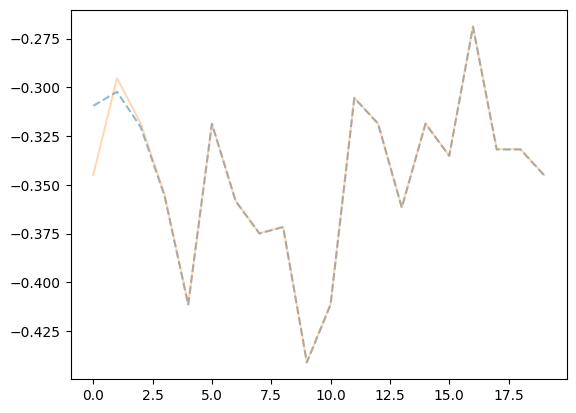

In [19]:
plt.plot(all_predictions_test[0][0], linestyle='--', alpha=0.5)
plt.plot(all_actuals_test[0][0], alpha=0.3)

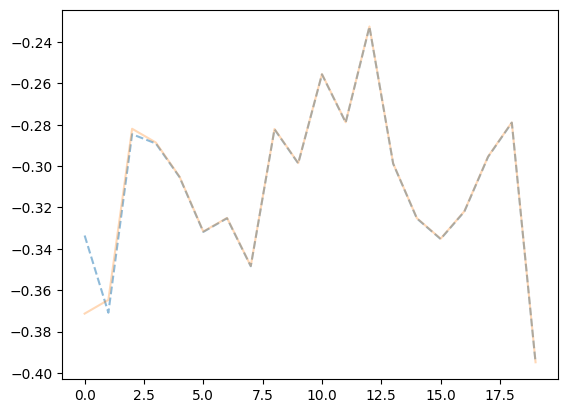

In [20]:
plt.plot(all_predictions_test[1][1], linestyle='--', alpha=0.5)
plt.plot(all_actuals_test[1][1], alpha=0.3)

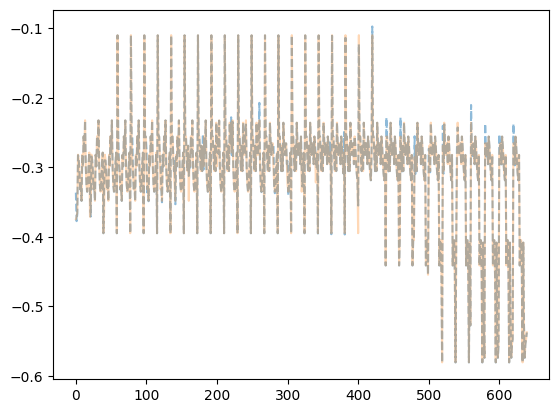

In [21]:
plt.plot(all_predictions_test[1].reshape(-1), linestyle='--', alpha=0.5)
plt.plot(all_actuals_test[1].reshape(-1), alpha=0.3)

In [22]:
# preds = np.concatenate(all_predictions_test, axis=0)
# final_predictions = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
# actuals = np.concatenate(all_actuals_test, axis=0)
# final_actuals = scaler.inverse_transform(actuals.reshape(-1,1)).flatten()
# plt.plot(final_actuals, label='Actual Spread')
# plt.plot(final_predictions, label='Predicted Spread (LSTM-KF)')
# plt.legend()
# plt.show()

#### 테스트에서의 예측 결과를 가지고 백테스트

In [23]:
preds = np.concatenate(all_predictions_test, axis=0)
actuals = np.concatenate(all_actuals_test, axis=0)
final_predictions = scaler.inverse_transform(preds.reshape(-1,1)).flatten()
final_actuals = scaler.inverse_transform(actuals.reshape(-1,1)).flatten()

In [24]:
print(preds.shape)
print(actuals.shape)

(196, 20)
(196, 20)


In [25]:
# 예측값 평균내기 (그래서 날짜 별로 펼쳐주기 위한 목적)
num_windows = preds.shape[0]  # 187
window_size  = preds.shape[1]  # 20
full_length  = num_windows + (window_size - 1)

# 누적 배열과 카운트 배열 준비
agg_pred = np.zeros(full_length, dtype=float)
counts = np.zeros(full_length, dtype=int)

# 각 윈도우 i, 윈도우 내 타임스텝 j에 대해
for i in range(num_windows):
  for j in range(window_size):
    t = i + j            # 실제 날짜 인덱스
    agg_pred[t] += preds[i, j]
    counts[t]   += 1

# 날짜별로 평균 내기
final_pred = agg_pred / counts

In [26]:
# 실제값 평균내기 (어차피 값이 다 같으므로 원래값 나옴)
num_windows = actuals.shape[0]  # 187
window_size  = actuals.shape[1]  # 20
full_length  = num_windows + (window_size - 1)

# 누적 배열과 카운트 배열 준비
agg_act = np.zeros(full_length, dtype=float)
counts = np.zeros(full_length, dtype=int)

# 각 윈도우 i, 윈도우 내 타임스텝 j에 대해
for i in range(num_windows):
  for j in range(window_size):
    t = i + j            # 실제 날짜 인덱스
    agg_act[t] += actuals[i, j]
    counts[t]   += 1

# 날짜별로 평균 내기
final_act = agg_act / counts

In [27]:
print(agg_pred.shape)
print(agg_act.shape)
print(final_pred.shape)
print(final_act.shape)

(215,)
(215,)
(215,)
(215,)


In [28]:
predictions_invscaled = scaler.inverse_transform(final_pred.reshape(-1,1))
actuals_invscaled = scaler.inverse_transform(final_act.reshape(-1,1))

In [29]:
print(predictions_invscaled.shape)

(215, 1)


In [30]:
from pandas.tseries.offsets import BusinessDay

test_ = train_size + val_size
start_date_ = pd.to_datetime(start_date)
offset_bd = BusinessDay(test_)
test_start_date = start_date_ + offset_bd

In [31]:
dates = pd.date_range(start=test_start_date, periods=full_length, freq='B')
final_pred_series = pd.Series(predictions_invscaled.flatten(), index=dates)
final_actual_series = pd.Series(actuals_invscaled.flatten(), index=dates)
final_df = pd.concat([final_pred_series, final_actual_series], axis=1)

In [32]:
final_df.describe()

,0,1
count,215.000000,215.000000
mean,1.589648,1.585244
std,0.279361,0.280769
min,0.642018,0.633911
25%,1.424962,1.420883
50%,1.604301,1.600494
75%,1.743271,1.740013
max,2.389686,2.389999


In [46]:
# 전략 파라미터 설정
param_rolling_window = 20
param_std_dev_multiplier = 1.0
param_initial_capital = 100000.0
param_commission_rate = 0.001

<ipython-input-9-b534408b6181>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['StrategyReturns_Raw'].fillna(0, inplace=True)



--- 백테스팅 성과 (2024-03-22 ~ 2025-01-16) ---
초기 자본: 100,000
최종 자산: 100,003.72
총 수익률: 0.00%
CAGR (연평균 수익률): 0.00%
최대 낙폭 (MDD): -0.00%
샤프 지수 (연율화): 1.43
총 거래 횟수: 11


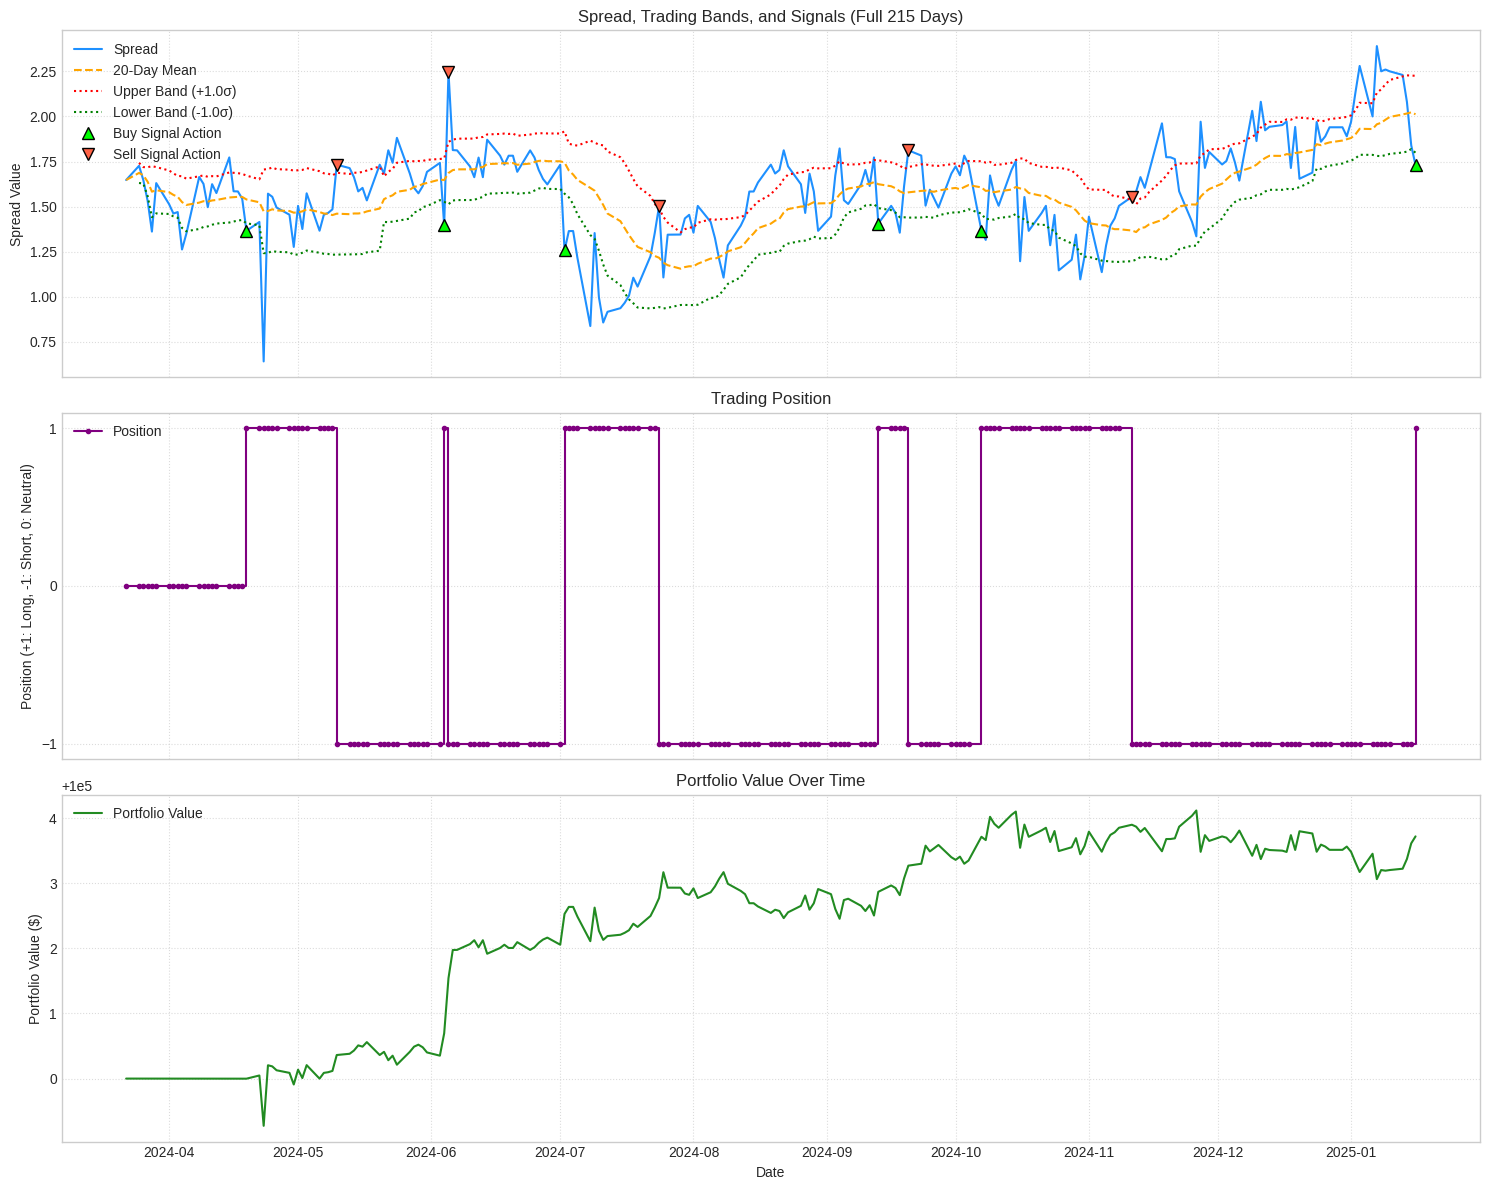

In [50]:
# 예측 값으로 백테스팅 한 결과
pred_results, pred_metrics = run_and_visualize_backtest(
  spread_series=final_pred_series,
  rolling_window=param_rolling_window,
  std_dev_multiplier=param_std_dev_multiplier,
  initial_capital=param_initial_capital,
  commission_rate=param_commission_rate
)

<ipython-input-9-b534408b6181>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['StrategyReturns_Raw'].fillna(0, inplace=True)



--- 백테스팅 성과 (2024-03-22 ~ 2025-01-16) ---
초기 자본: 100,000
최종 자산: 100,003.75
총 수익률: 0.00%
CAGR (연평균 수익률): 0.00%
최대 낙폭 (MDD): -0.00%
샤프 지수 (연율화): 1.43
총 거래 횟수: 11


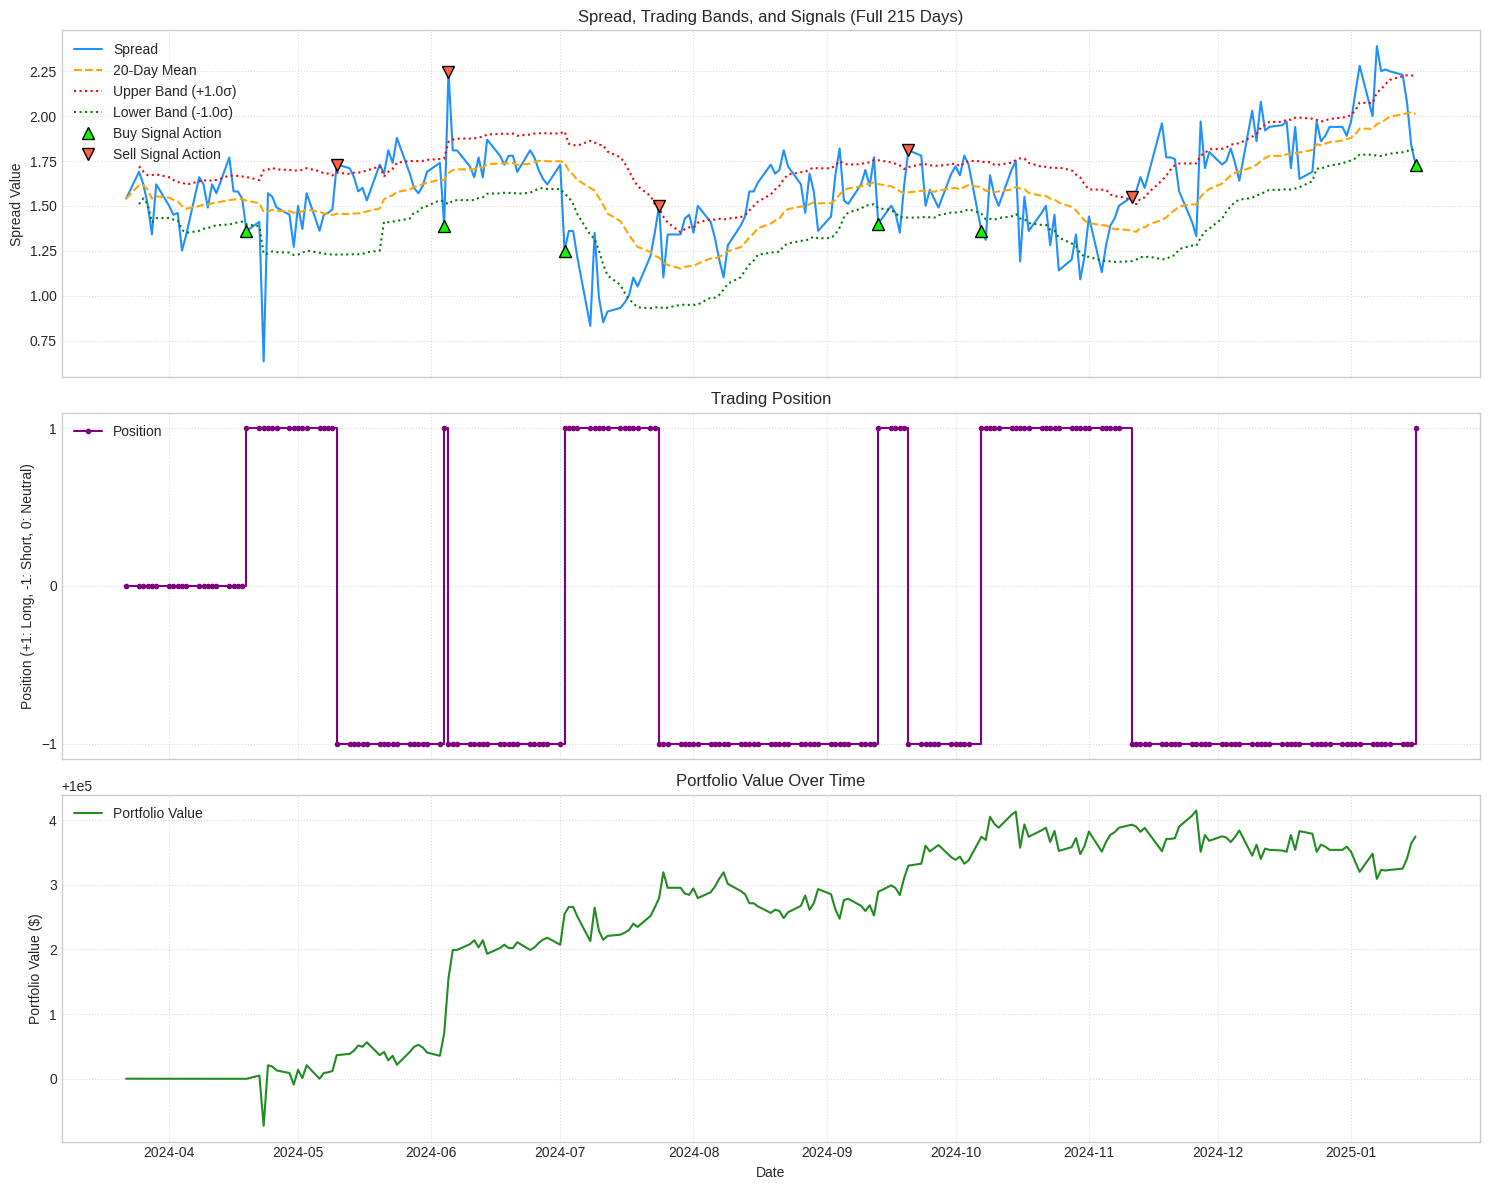

In [53]:
# 실제 데이터로 백테스팅한 결과
act_results, act_metrics = run_and_visualize_backtest(
  spread_series=final_actual_series,
  rolling_window=param_rolling_window,
  std_dev_multiplier=param_std_dev_multiplier,
  initial_capital=param_initial_capital,
  commission_rate=param_commission_rate
)

In [54]:
act_results

,Spread,Mean,StdDev,UpperBand,LowerBand,Position,Signal,StrategyReturns_Raw,TransactionCost,Cash,Holdings_Spread_Units,PortfolioValue,Commission,StrategyReturns,CumulativeStrategyReturns,PeakValue,Drawdown
Date,,,,,,,,,,,,,,,,,
2024-03-22,1.540558,1.540558,NaN,NaN,NaN,0,0.0,0.000000,0.0,100000.000000,0.0,100000.000000,0.00000,0.000000e+00,0.000000,100000.000000,0.000000
2024-03-25,1.689865,1.615211,0.105576,1.720788,1.509635,0,0.0,0.000000,0.0,100000.000000,0.0,100000.000000,0.00000,0.000000e+00,0.000000,100000.000000,0.000000
2024-03-26,1.620117,1.616847,0.074707,1.691554,1.542139,0,0.0,-0.000000,0.0,100000.000000,0.0,100000.000000,0.00000,0.000000e+00,0.000000,100000.000000,0.000000
2024-03-27,1.510529,1.590267,0.080912,1.671179,1.509356,0,0.0,-0.000000,0.0,100000.000000,0.0,100000.000000,0.00000,0.000000e+00,0.000000,100000.000000,0.000000
2024-03-28,1.341415,1.540497,0.131512,1.672009,1.408985,0,0.0,-0.000000,0.0,100000.000000,0.0,100000.000000,0.00000,0.000000e+00,0.000000,100000.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2025-01-10,2.250000,1.996513,0.205442,2.201955,1.791070,-1,0.0,0.009995,0.0,99999.970155,-1.0,100003.229906,0.00000,9.994203e-08,0.000032,100004.148866,-0.000009
2025-01-13,2.229996,2.010515,0.211554,2.222069,1.798961,-1,0.0,0.020004,0.0,99999.970155,-1.0,100003.249910,0.00000,2.000365e-07,0.000032,100004.148866,-0.000009
2025-01-14,2.080002,2.016020,0.211874,2.227894,1.804146,-1,0.0,0.149994,0.0,99999.970155,-1.0,100003.399904,0.00000,1.499891e-06,0.000034,100004.148866,-0.000007


#### 추론

In [33]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [34]:
# 필요한 부분만 발췌
# 훈련 시 입력은 y_seq_scaled, 타겟도 y_seq_scaled (모델 출력 x_preds와 비교)
# train_dataset_model = TensorDataset(torch.tensor(y_seq_train_scaled, dtype=torch.float32))
# val_dataset_model = TensorDataset(torch.tensor(y_seq_val_scaled, dtype=torch.float32))
# test_dataset_model = TensorDataset(torch.tensor(y_seq_test_scaled, dtype=torch.float32))

# train_loader_model = DataLoader(train_dataset_model, batch_size=BATCH_SIZE_DL, shuffle=True) # 훈련 시 셔플 가능
# val_loader_model = DataLoader(val_dataset_model, batch_size=BATCH_SIZE_DL, shuffle=False)
# test_loader_model = DataLoader(test_dataset_model, batch_size=BATCH_SIZE_DL, shuffle=False)

In [35]:
# 추론에 쓸 데이터 꺼내기
last_batch = None
for batch in test_loader_model:
  last_batch = batch

In [36]:
last_batch[0].shape

torch.Size([4, 20])

In [37]:
last_seq = last_batch[0][-1]
last_seq_reshaped = last_seq.unsqueeze(0)

In [38]:
last_seq_reshaped.size(0)

1

In [39]:
model_instance.eval()
with torch.no_grad():
  preds = []
  # 20일치 예측
  # y_batch_test = y_batch_test.to(DEVICE_MODEL)
  initial_x0_test = torch.zeros(last_seq_reshaped.size(0), device=DEVICE_MODEL)
  initial_P0_test = torch.ones(last_seq_reshaped.size(0), device=DEVICE_MODEL)

  x_predictions_test = model_instance(last_seq_reshaped, x0=initial_x0_test, P0=initial_P0_test)
  preds.append(x_predictions_test.cpu().numpy())

In [40]:
print(len(preds))
print(preds[0].shape)

1
(1, 20)


In [41]:
outputs_np = np.concatenate(preds, axis=0)
predictions = scaler.inverse_transform(outputs_np)

In [42]:
predictions[0]

array([1.747222 , 1.6733857, 1.9626236, 1.8590027, 1.8894248, 1.9396173,
       1.9396989, 1.8897183, 1.9696829, 2.1296961, 2.2797925, 1.9999087,
       2.389686 , 2.2499366, 2.259847 , 2.2498598, 2.2298524, 2.0798688,
       1.8398106, 1.7296861], dtype=float32)

In [100]:
today + pd.offsets.BusinessDay(1)

Timestamp('2025-06-02 00:00:00')

In [103]:
num_future_days = 20
today = datetime.date.today()
start_date_ = today + pd.offsets.BusinessDay(1)
future_dates = pd.date_range(start=start_date_, periods=num_future_days, freq='B')
df_predictions_indexed = pd.Series(predictions[0], index=future_dates)

<ipython-input-9-b534408b6181>:66: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  df['StrategyReturns_Raw'].fillna(0, inplace=True)



--- 백테스팅 성과 (2025-06-02 ~ 2025-06-27) ---
초기 자본: 100,000
최종 자산: 100,000.00
총 수익률: -0.00%
CAGR (연평균 수익률): -0.00%
최대 낙폭 (MDD): -0.00%
샤프 지수 (연율화): -3.55
총 거래 횟수: 1


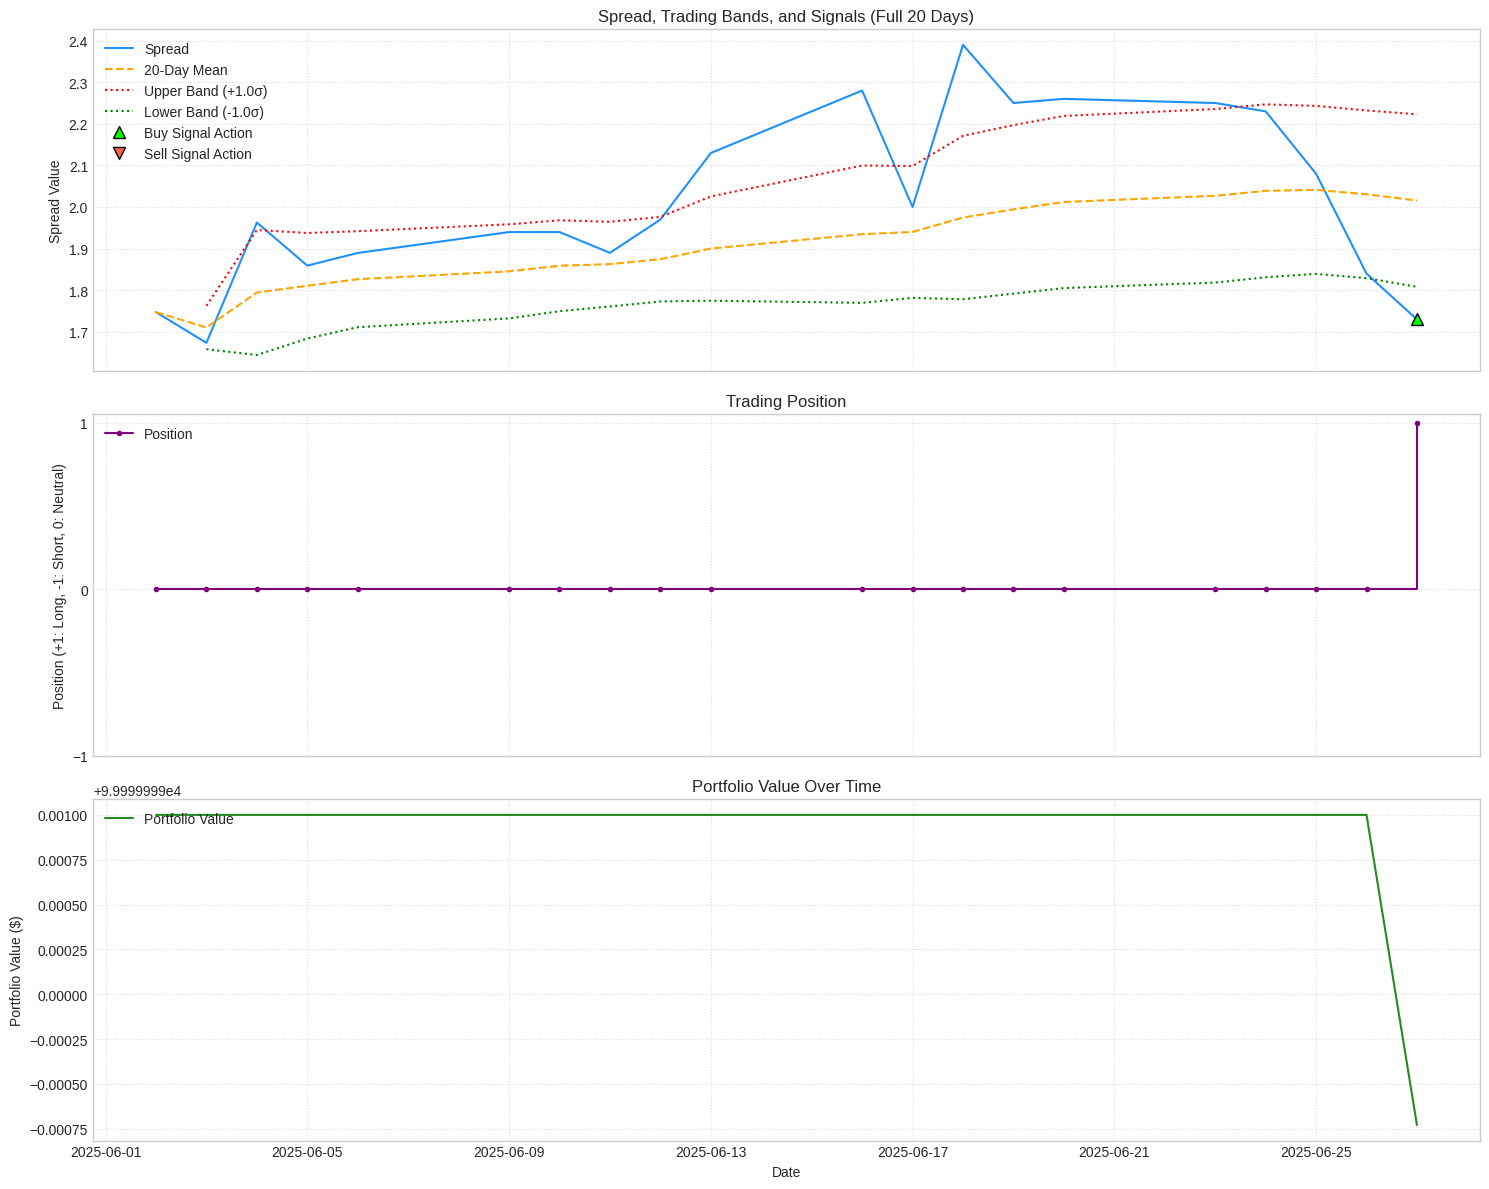

In [105]:
infer_results, infer_metrics = run_and_visualize_backtest(
  spread_series=df_predictions_indexed,
  rolling_window=param_rolling_window,
  std_dev_multiplier=param_std_dev_multiplier,
  initial_capital=param_initial_capital,
  commission_rate=param_commission_rate
)

## Old Ver

#### LSTM-KF모델

In [ ]:
import torch
import torch.nn as nn
from torch.autograd.functional import jacobian # 자코비안 계산용

# ==============================================================================
# 1. LSTM-KF 모델 클래스
# ==============================================================================
class LSTM_KF_Model(nn.Module):
  def __init__(self,
                state_dim=1,            # 상태 변수의 차원
                measurement_dim=1,      # 관측 변수의 차원 (스프레드의 경우 state_dim과 동일)
                lstm_f_hidden_size=64,
                lstm_q_hidden_size=32,
                lstm_r_hidden_size=32,
                lstm_f_num_layers=1,
                lstm_q_num_layers=1,
                lstm_r_num_layers=1):
      super(LSTM_KF_Model, self).__init__()

      self.state_dim = state_dim
      self.measurement_dim = measurement_dim

      # --- LSTM_f: y_hat_{t-1} -> y_prime_t (상태 전이 함수 f) ---
      # 입력 차원은 state_dim (y_hat_{t-1}의 차원)
      self.lstm_f_module = nn.LSTM(input_size=self.state_dim,
                                    hidden_size=lstm_f_hidden_size,
                                    num_layers=lstm_f_num_layers,
                                    batch_first=True)
      self.fc_f = nn.Linear(lstm_f_hidden_size, self.state_dim) # y_prime_t

      # --- LSTM_Q: y_prime_t -> Q_t (프로세스 노이즈) ---
      # 입력 차원은 state_dim (y_prime_t의 차원)
      self.lstm_q_module = nn.LSTM(input_size=self.state_dim,
                                    hidden_size=lstm_q_hidden_size,
                                    num_layers=lstm_q_num_layers,
                                    batch_first=True)
      # Q_t의 대각 성분 (log scale) -> state_dim 개
      self.fc_q = nn.Linear(lstm_q_hidden_size, self.state_dim)

      # --- LSTM_R: z_t -> R_t (측정 노이즈) ---
      # 입력 차원은 measurement_dim (z_t의 차원)
      self.lstm_r_module = nn.LSTM(input_size=self.measurement_dim,
                                    hidden_size=lstm_r_hidden_size,
                                    num_layers=lstm_r_num_layers,
                                    batch_first=True)
      # R_t의 대각 성분 (log scale) -> measurement_dim 개
      self.fc_r = nn.Linear(lstm_r_hidden_size, self.measurement_dim)

      # --- 관측 행렬 H ---
      # 상태와 관측이 동일한 '스프레드'이고, state_dim == measurement_dim 이라 가정하고 Identity로 설정.
      # 만약 state_dim != measurement_dim 이거나 다른 관측 모델이 필요하면 직접 설계/전달 필요.
      if self.state_dim != self.measurement_dim:
          # 이 경우 H는 사용자가 직접 정의해야 함 (예: nn.Linear 또는 고정 행렬)
          # 여기서는 간단히 Identity로 초기화하나, 실제 사용 시 주의
          print(f"Warning: state_dim ({self.state_dim}) != measurement_dim ({self.measurement_dim}). "
                f"H is set to Identity but might need specific design.")
      # H를 버퍼로 등록하여 GPU 이동 등을 자동화하고 학습되지 않도록 함.
      self.register_buffer('H_matrix', torch.eye(self.measurement_dim, self.state_dim, dtype=torch.float32))


  # LSTM_f를 위한 별도 함수 (자코비안 계산용)
  def _compute_y_prime_t(self, y_hat_t_minus_1_for_f, h_c_f=None):
      # y_hat_t_minus_1_for_f: (batch, 1, state_dim)
      if h_c_f is not None:
          lstm_f_out, next_h_c_f = self.lstm_f_module(y_hat_t_minus_1_for_f, h_c_f)
      else:
          lstm_f_out, next_h_c_f = self.lstm_f_module(y_hat_t_minus_1_for_f)
      y_prime_t = self.fc_f(lstm_f_out) # (batch, 1, state_dim)
      return y_prime_t, next_h_c_f

  def forward(self, z_sequence, initial_y_hat, initial_P):
      """
      Args:
          z_sequence: 관측값 시퀀스 (batch_size, seq_len, measurement_dim)
          initial_y_hat: 초기 상태 추정 (batch_size, state_dim)
          initial_P: 초기 상태 공분산 (batch_size, state_dim, state_dim)
      Returns:
          y_hat_sequence: 필터링된 상태 추정치 시퀀스 (batch_size, seq_len, state_dim)
          P_sequence: 필터링된 오차 공분산 시퀀스 (batch_size, seq_len, state_dim, state_dim)
          y_prime_sequence: 중간 상태(사전 예측) 시퀀스 (batch_size, seq_len, state_dim)
      """
      batch_size, seq_len, _ = z_sequence.shape
      device = z_sequence.device

      # 현재 y_hat_{t-1}과 P_{t-1}
      y_hat_t_minus_1 = initial_y_hat        # (batch, state_dim)
      P_t_minus_1 = initial_P                # (batch, state_dim, state_dim)

      # LSTM 은닉 상태 초기화 (0으로 시작, 필요시 외부에서 전달받아 사용 가능)
      h_f, c_f = (torch.zeros(self.lstm_f_module.num_layers, batch_size, self.lstm_f_module.hidden_size, device=device),
                    torch.zeros(self.lstm_f_module.num_layers, batch_size, self.lstm_f_module.hidden_size, device=device))
      h_q, c_q = (torch.zeros(self.lstm_q_module.num_layers, batch_size, self.lstm_q_module.hidden_size, device=device),
                    torch.zeros(self.lstm_q_module.num_layers, batch_size, self.lstm_q_module.hidden_size, device=device))
      h_r, c_r = (torch.zeros(self.lstm_r_module.num_layers, batch_size, self.lstm_r_module.hidden_size, device=device),
                    torch.zeros(self.lstm_r_module.num_layers, batch_size, self.lstm_r_module.hidden_size, device=device))

      y_hat_list = []
      P_list = []
      y_prime_list_for_loss = [] # 손실 함수용 y_prime_t 저장

      for t in range(seq_len):
          # --- 1. LSTM_f 로 y_prime_t (ŷ'_t, 사전 상태 예측치) 생성 ---
          # _compute_y_prime_t 함수를 호출하기 위해 y_hat_t_minus_1을 (B,1,state_dim)으로 만듦
          y_hat_t_minus_1_for_f_input = y_hat_t_minus_1.unsqueeze(1)

          # 자코비안 계산을 위해 y_hat_t_minus_1_for_f_input에 대한 그래디언트 추적 활성화
          y_hat_t_minus_1_for_f_input.requires_grad_(True)

          # 자코비안 계산은 배치 단위로 수행해야 함. 루프 사용.
          F_t_batch_list = []
          y_prime_t_batch_list = []

          for b_idx in range(batch_size):
              # _compute_y_prime_t에 전달할 은닉 상태 (배치 차원 제거)
              h_f_b = h_f[:, b_idx:b_idx+1, :].contiguous()
              c_f_b = c_f[:, b_idx:b_idx+1, :].contiguous()

              # 자코비안 계산 함수 (단일 샘플에 대해)
              # functional_y_prime_t는 y_hat_t_minus_1_for_f_input[b_idx:b_idx+1]을 클로저로 참조
              def functional_y_prime_t_single_sample(inp_y_hat_tm1):
                  # inp_y_hat_tm1: (1, 1, state_dim)
                  # _compute_y_prime_t는 (h_c_f)도 받음
                  y_p, _ = self._compute_y_prime_t(inp_y_hat_tm1, (h_f_b, c_f_b))
                  return y_p.squeeze(1) # (1, state_dim) -> (state_dim) for jacobian

              # 현재 샘플에 대한 y_hat_{t-1}
              current_sample_y_hat_tm1 = y_hat_t_minus_1_for_f_input[b_idx:b_idx+1] # (1,1,state_dim)

              # 실제 y_prime_t 계산 (다음 은닉 상태 업데이트 위함)
              y_prime_t_sample, (h_f_b_next, c_f_b_next) = self._compute_y_prime_t(current_sample_y_hat_tm1, (h_f_b, c_f_b))
              y_prime_t_batch_list.append(y_prime_t_sample.squeeze(1)) # (state_dim)

              # 다음 루프 또는 다음 시퀀스 요소에서 사용할 은닉 상태 업데이트
              h_f[:, b_idx:b_idx+1, :] = h_f_b_next
              c_f[:, b_idx:b_idx+1, :] = c_f_b_next

              if self.training: # 훈련 시에만 자코비안 계산 (역전파 필요시)
                  F_t_sample = jacobian(functional_y_prime_t_single_sample, current_sample_y_hat_tm1, create_graph=True)
                  # F_t_sample의 shape: (output_dim, input_dim_elements...)
                  # functional_y_prime_t_single_sample의 출력은 (state_dim)
                  # current_sample_y_hat_tm1의 입력은 (1,1,state_dim)
                  # jacobian 결과는 (state_dim, 1, 1, state_dim) 형태일 수 있음.
                  # 우리가 원하는 F_t는 (state_dim, state_dim)
                  F_t_sample = F_t_sample.squeeze().reshape(self.state_dim, self.state_dim)
                  F_t_batch_list.append(F_t_sample)
              else: # 평가 시에는 자코비안 계산 생략하고 Identity로 (또는 다른 근사)
                  F_t_batch_list.append(torch.eye(self.state_dim, device=device))


          y_prime_t = torch.stack(y_prime_t_batch_list, dim=0) # (batch_size, state_dim)
          F_t = torch.stack(F_t_batch_list, dim=0)             # (batch_size, state_dim, state_dim)
          y_prime_list_for_loss.append(y_prime_t)

          # y_hat_t_minus_1_for_f_input의 그래디언트 추적 비활성화
          y_hat_t_minus_1_for_f_input.requires_grad_(False)


          # --- 2. LSTM_Q 로 Q_t 추정 ---
          y_prime_t_for_q_input = y_prime_t.unsqueeze(1) # (batch, 1, state_dim)
          lstm_q_out, (h_q, c_q) = self.lstm_q_module(y_prime_t_for_q_input, (h_q, c_q))
          log_Q_diag_t = self.fc_q(lstm_q_out.squeeze(1))   # (batch, state_dim)
          Q_diag_t = torch.exp(log_Q_diag_t)                # Positive definite
          Q_t = torch.diag_embed(Q_diag_t)                  # (batch, state_dim, state_dim)

          # --- 3. LSTM_R 로 R_t 추정 ---
          z_t_for_r_input = z_sequence[:, t, :].unsqueeze(1) # (batch, 1, measurement_dim)
          lstm_r_out, (h_r, c_r) = self.lstm_r_module(z_t_for_r_input, (h_r, c_r))
          log_R_diag_t = self.fc_r(lstm_r_out.squeeze(1))   # (batch, measurement_dim)
          R_diag_t = torch.exp(log_R_diag_t)                # Positive definite
          R_t = torch.diag_embed(R_diag_t)                  # (batch, measurement_dim, measurement_dim)

          # --- 4. 칼만 필터 예측 (Prediction step) ---
          # y_hat_minus_t = F_t @ y_hat_t_minus_1 (논문 Eq.16은 y'_t = f(y_hat_{t-1}))
          # 여기서는 y_prime_t (LSTM_f의 출력)가 y_hat_minus_t 역할을 함
          y_hat_minus_t = y_prime_t # (batch, state_dim)
          # P_minus_t = F_t @ P_t_minus_1 @ F_t.transpose(1,2) + Q_t (논문 Eq.17)
          P_minus_t = F_t @ P_t_minus_1 @ F_t.transpose(1, 2) + Q_t

          # --- 5. 칼만 필터 업데이트 (Update step) ---
          # K_t = P_minus_t @ H.T @ torch.inverse(H @ P_minus_t @ H.T + R_t) (논문 Eq.18)
          # y_hat_t = y_hat_minus_t + K_t @ (z_t - H @ y_hat_minus_t) (논문 Eq.19)
          # P_t = (I - K_t @ H) @ P_minus_t (논문 Eq.20)
          H = self.H_matrix.unsqueeze(0).repeat(batch_size, 1, 1) # (batch, meas_dim, state_dim)

          S_t_intermediate = H @ P_minus_t @ H.transpose(1, 2) + R_t # (B, meas_dim, meas_dim)
          # S_t_inv = torch.inverse(S_t_intermediate) # 안정성을 위해 pseudo-inverse 고려 가능
          # 수치 안정성을 위해 작은 값(epsilon)을 대각선에 더할 수 있음
          epsilon = 1e-6
          S_t_inv = torch.inverse(S_t_intermediate + epsilon * torch.eye(self.measurement_dim, device=device).unsqueeze(0))

          K_t = P_minus_t @ H.transpose(1, 2) @ S_t_inv # (B, state_dim, meas_dim) Kalman Gain

          z_t_current_obs = z_sequence[:, t, :] # (B, meas_dim)
          residual = z_t_current_obs - (H @ y_hat_minus_t.unsqueeze(-1)).squeeze(-1) # (B, meas_dim)
          y_hat_t = y_hat_minus_t + (K_t @ residual.unsqueeze(-1)).squeeze(-1) # (B, state_dim)

          I_matrix = torch.eye(self.state_dim, device=device).unsqueeze(0).repeat(batch_size, 1, 1)
          P_t = (I_matrix - K_t @ H) @ P_minus_t

          y_hat_list.append(y_hat_t)
          P_list.append(P_t)

          # 다음 스텝을 위해 현재 추정치를 이전 추정치로 업데이트
          y_hat_t_minus_1 = y_hat_t
          P_t_minus_1 = P_t

      y_hat_sequence_final = torch.stack(y_hat_list, dim=1)
      P_sequence_final = torch.stack(P_list, dim=1)
      y_prime_sequence_for_loss_final = torch.stack(y_prime_list_for_loss, dim=1)

      return y_hat_sequence_final, P_sequence_final, y_prime_sequence_for_loss_final

In [ ]:
# ==============================================================================
# 2. 손실 함수 (논문 Eq. 21)
# ==============================================================================
class LSTM_KFLoss(nn.Module):
  def __init__(self, lambda_y_prime=0.8, reduction='mean'): # 기본 reduction을 mean으로 변경
    super(LSTM_KFLoss, self).__init__()
    self.lambda_y_prime = lambda_y_prime
    # MSELoss의 reduction에 따라 1/T 항 등의 처리가 달라짐
    # reduction='mean': 배치 및 모든 요소에 대한 평균
    # reduction='sum': 모든 요소의 합
    self.mse_loss_term = nn.MSELoss(reduction=reduction)

  def forward(self, y_hat_sequence, y_prime_sequence, target_sequence):
    # y_hat_sequence: (batch, seq_len, state_dim) - KF 최종 예측
    # y_prime_sequence: (batch, seq_len, state_dim) - LSTM_f 중간 예측
    # target_sequence: (batch, seq_len, state_dim) - 실제 값 (훈련 시 z_sequence 사용)

    loss_y_hat = self.mse_loss_term(y_hat_sequence, target_sequence)
    loss_y_prime = self.mse_loss_term(y_prime_sequence, target_sequence)

    total_loss = loss_y_hat + self.lambda_y_prime * loss_y_prime

    # 만약 논문의 1/T를 명시적으로 적용하고 싶고, reduction='sum'을 사용했다면:
    # T = y_hat_sequence.size(1) # seq_len
    # total_loss = (loss_y_hat + self.lambda_y_prime * loss_y_prime) / T
    # (하지만 MSELoss(reduction='mean')이 더 일반적)

    return total_loss

#### 데이터준비 ver.3 (수정된 LSTM-KF을 위한 스프레드 준비)

In [ ]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import DataLoader, TensorDataset
from sklearn.preprocessing import MinMaxScaler # 정규화용 (예시, 다른 스케일러 사용 가능)


# ==============================================================================
# 1. 데이터프레임 생성 및 스프레드 계산 (사용자 코드 기반)
# ==============================================================================
ticker_a = 'GOOGL_Close' # 컬럼 이름 명확히 (또는 실제 컬럼명 사용)
ticker_c = 'GOOG_Close'
df = pd.DataFrame({ticker_a: GOOGL1['Close'], ticker_c: GOOG1['Close']})
df.ffill(inplace=True)
df.bfill(inplace=True)
df.dropna(inplace=True)

if df.empty:
  raise ValueError("데이터를 불러오지 못했거나 데이터가 비어있습니다.")

df['Spread'] = df[ticker_a] - df[ticker_c]
spread_values = df['Spread'].values.astype(np.float32) # Numpy 배열로 변환

# ==============================================================================
# 2. 시계열 데이터를 지도 학습 형태로 변환하는 함수 (LSTM-KF 모델에 맞게 수정)
# ==============================================================================
def create_kf_sequences(data, seq_length):
  """
  LSTM-KF 모델 입력을 위한 시퀀스를 생성합니다.
  z_sequence (관측 시퀀스)와 target_sequence (실제 상태 시퀀스, 훈련 시 z_sequence와 동일)를 반환합니다.
  각 시퀀스는 (num_samples, seq_length, 1) 형태를 가집니다.
  """
  xs = [] # z_sequence (관측값)
  ys = [] # target_sequence (y_t, 실제 상태값 - 훈련 시 z_t와 동일)

  if len(data) <= seq_length:
      print(f"Warning: 데이터 길이({len(data)})가 시퀀스 길이({seq_length})보다 작거나 같습니다. 시퀀스를 생성할 수 없습니다.")
      return np.array(xs), np.array(ys)

  for i in range(len(data) - seq_length): # 수정: 마지막 샘플까지 포함하도록 (또는 +1 할지 결정)
                                          # 만약 data[i + seq_length]가 target이면 len(data) - seq_length
                                          # 만약 data[i:i+seq_length]가 target이면 len(data) - seq_length + 1
    # LSTM-KF는 현재 시점 t까지의 관측 z_t를 보고 현재 상태 y_t를 추정.
    # 따라서 z_sequence와 target_sequence는 동일한 시간 윈도우를 가짐.
    x_seq = data[i:(i + seq_length)]
    y_seq = data[i:(i + seq_length)] # 훈련 시 y_t는 z_t로 근사
    xs.append(x_seq)
    ys.append(y_seq)

  # (num_samples, seq_length) -> (num_samples, seq_length, 1)로 변환
  return np.array(xs)[..., np.newaxis], np.array(ys)[..., np.newaxis]

# ==============================================================================
# 3. 시퀀스 생성 및 분할 (이전 코드의 SEQ_LEN 변수 사용)
# ==============================================================================
# SEQ_LEN은 LSTM-KF 모델의 훈련 루프에서 정의된 값을 사용한다고 가정
# 만약 이 파일에서 직접 정의해야 한다면:
# SEQ_LEN = 20 # 예시: LSTM-KF 모델에 사용할 시퀀스 길이

# 전역 변수로 SEQ_LEN이 정의되어 있다고 가정하고 사용
# (만약 없다면 위에서 주석 해제 또는 적절한 값으로 설정)
if 'SEQ_LEN' not in globals():
    print("Warning: SEQ_LEN is not defined globally. Setting to default 20 for data preparation.")
    SEQ_LEN = 20 # 이전 LSTM-KF 코드의 기본값

# z_sequences는 관측값, target_sequences는 y_t (훈련 시 z_t로 근사)
z_sequences, target_sequences = create_kf_sequences(spread_values, SEQ_LEN)

if z_sequences.shape[0] == 0:
  raise ValueError(f"시퀀스 생성 후 데이터가 없습니다. 데이터 기간이나 SEQ_LEN({SEQ_LEN})을 확인하세요.")

print(f"z_sequences shape: {z_sequences.shape}")       # 예: (N, SEQ_LEN, 1)
print(f"target_sequences shape: {target_sequences.shape}") # 예: (N, SEQ_LEN, 1)

# 데이터 분할 (훈련, 검증, 테스트)
total_samples = z_sequences.shape[0]
train_split_ratio = 0.7
val_split_ratio = 0.15

train_size = int(total_samples * train_split_ratio)
val_size = int(total_samples * val_split_ratio)
# test_size = total_samples - train_size - val_size (필요시)

Z_train, Y_train = z_sequences[:train_size], target_sequences[:train_size]
Z_val, Y_val = z_sequences[train_size:train_size + val_size], target_sequences[train_size:train_size + val_size]
Z_test, Y_test = z_sequences[train_size + val_size:], target_sequences[train_size + val_size:]

print(f"\nTrain shapes: Z_train: {Z_train.shape}, Y_train: {Y_train.shape}")
print(f"Validation shapes: Z_val: {Z_val.shape}, Y_val: {Y_val.shape}")
print(f"Test shapes: Z_test: {Z_test.shape}, Y_test: {Y_test.shape}")

# ==============================================================================
# 4. 정규화 (MinMaxScaler 사용)
# ==============================================================================
scaler_spread = MinMaxScaler(feature_range=(-1, 1))

# Scaler는 훈련 데이터(Z_train)에만 fit
# (num_samples, seq_length, 1) -> (num_samples * seq_length, 1)로 reshape 후 fit
Z_train_reshaped = Z_train.reshape(-1, 1)
scaler_spread.fit(Z_train_reshaped)

# 모든 데이터 (Z 및 Y)를 동일한 스케일러로 변환
Z_train_scaled = scaler_spread.transform(Z_train_reshaped).reshape(Z_train.shape)
Y_train_scaled = scaler_spread.transform(Y_train.reshape(-1,1)).reshape(Y_train.shape) # Y도 동일하게

Z_val_scaled = scaler_spread.transform(Z_val.reshape(-1, 1)).reshape(Z_val.shape)
Y_val_scaled = scaler_spread.transform(Y_val.reshape(-1,1)).reshape(Y_val.shape)

Z_test_scaled = scaler_spread.transform(Z_test.reshape(-1, 1)).reshape(Z_test.shape)
Y_test_scaled = scaler_spread.transform(Y_test.reshape(-1,1)).reshape(Y_test.shape)

print("\nData scaled.")
print(f"Z_train_scaled sample (first sequence, first 3 values): \n{Z_train_scaled[0, :3, :]}")
print(f"Y_train_scaled sample (first sequence, first 3 values): \n{Y_train_scaled[0, :3, :]}")


# ==============================================================================
# 5. PyTorch Tensor로 변환 및 DataLoader 생성
# ==============================================================================
# BATCH_SIZE는 LSTM-KF 모델의 훈련 루프에서 정의된 값을 사용한다고 가정
# 만약 이 파일에서 직접 정의해야 한다면:
# BATCH_SIZE = 32 # 예시: DataLoader에서 사용할 배치 크기

if 'BATCH_SIZE' not in globals():
    print("Warning: BATCH_SIZE is not defined globally. Setting to default 32 for DataLoader.")
    BATCH_SIZE = 32 # 이전 LSTM-KF 코드의 기본값

# 훈련/검증/테스트 데이터셋 텐서로 변환
# LSTM-KF 모델의 입력은 z_sequence (관측값), 타겟은 target_sequence (실제 상태값)
train_z_tensor = torch.tensor(Z_train_scaled, dtype=torch.float32)
train_y_tensor = torch.tensor(Y_train_scaled, dtype=torch.float32) # target_sequence
val_z_tensor = torch.tensor(Z_val_scaled, dtype=torch.float32)
val_y_tensor = torch.tensor(Y_val_scaled, dtype=torch.float32)
test_z_tensor = torch.tensor(Z_test_scaled, dtype=torch.float32)
test_y_tensor = torch.tensor(Y_test_scaled, dtype=torch.float32)

# TensorDataset 생성
train_dataset_kf = TensorDataset(train_z_tensor, train_y_tensor)
val_dataset_kf = TensorDataset(val_z_tensor, val_y_tensor)
test_dataset_kf = TensorDataset(test_z_tensor, test_y_tensor)

# DataLoader 생성
# 시계열 데이터이므로 shuffle=False가 일반적이나, 상태 초기화 등에 따라 shuffle=True도 가능
# 여기서는 일반적인 시계열 처리 방식인 shuffle=False를 따름
train_loader_kf = DataLoader(train_dataset_kf, batch_size=BATCH_SIZE, shuffle=False)
val_loader_kf = DataLoader(val_dataset_kf, batch_size=BATCH_SIZE, shuffle=False)
test_loader_kf = DataLoader(test_dataset_kf, batch_size=BATCH_SIZE, shuffle=False)

print("\nDataLoaders for LSTM-KF created (train_loader_kf, val_loader_kf, test_loader_kf).")
print(f"Number of training batches: {len(train_loader_kf)}")
print(f"Number of validation batches: {len(val_loader_kf)}")
print(f"Number of testing batches: {len(test_loader_kf)}")

# 이제 train_loader_kf, val_loader_kf, test_loader_kf를
# 이전에 제공된 LSTM-KF 모델 훈련 루프에서 사용할 수 있습니다.
# 예: for z_batch, target_batch in train_loader_kf:

z_sequences shape: (1237, 20, 1)
target_sequences shape: (1237, 20, 1)

Train shapes: Z_train: (865, 20, 1), Y_train: (865, 20, 1)
Validation shapes: Z_val: (185, 20, 1), Y_val: (185, 20, 1)
Test shapes: Z_test: (187, 20, 1), Y_test: (187, 20, 1)

Data scaled.
Z_train_scaled sample (first sequence, first 3 values): 
[[0.92764854]
 [0.896077  ]
 [0.8806967 ]]
Y_train_scaled sample (first sequence, first 3 values): 
[[0.92764854]
 [0.896077  ]
 [0.8806967 ]]

DataLoaders for LSTM-KF created (train_loader_kf, val_loader_kf, test_loader_kf).
Number of training batches: 28
Number of validation batches: 6
Number of testing batches: 6


#### 하이퍼파라미터 설정 및 모델 선언

In [ ]:
# ==============================================================================
# 3. 하이퍼파라미터 및 설정
# ==============================================================================
# --- 기본 파라미터 ---
STATE_DIM = 1         # 상태 변수 차원 (스프레드 1개)
MEASUREMENT_DIM = 1   # 관측 변수 차원 (스프레드 1개)
LSTM_F_HIDDEN = 32   # 논문의 작은 네트워크 예시 (16)보다 약간 크게 설정
LSTM_Q_HIDDEN = 16
LSTM_R_HIDDEN = 16
LSTM_F_LAYERS = 1
LSTM_Q_LAYERS = 1
LSTM_R_LAYERS = 1

# --- 훈련 파라미터 ---
NUM_EPOCHS = 50
BATCH_SIZE = 32
LEARNING_RATE = 1e-3
LAMBDA_Y_PRIME_LOSS = 0.8 # 논문 값
SEQ_LEN = 20 # 한 번에 처리할 시퀀스 길이 (예: 20일)

DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {DEVICE}")

Using device: cpu


In [ ]:
# ==============================================================================
# 4. 모델, 손실 함수, 옵티마이저 인스턴스화
# ==============================================================================
model = LSTM_KF_Model(
    state_dim=STATE_DIM,
    measurement_dim=MEASUREMENT_DIM,
    lstm_f_hidden_size=LSTM_F_HIDDEN,
    lstm_q_hidden_size=LSTM_Q_HIDDEN,
    lstm_r_hidden_size=LSTM_R_HIDDEN,
    lstm_f_num_layers=LSTM_F_LAYERS,
    lstm_q_num_layers=LSTM_Q_LAYERS,
    lstm_r_num_layers=LSTM_R_LAYERS
).to(DEVICE)

criterion = LSTM_KFLoss(lambda_y_prime=LAMBDA_Y_PRIME_LOSS)
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

#### 훈련

In [ ]:
# ==============================================================================
# 6. 훈련 및 검증 루프
# ==============================================================================
print("\nStarting training...")
for epoch in range(NUM_EPOCHS):
  # --- 훈련 ---
  model.train()
  epoch_train_loss = 0.0
  for i, (z_batch, target_batch) in enumerate(train_loader):
    z_batch = z_batch.to(DEVICE)
    target_batch = target_batch.to(DEVICE) # y_t 역할을 하는 실제 값
    current_batch_size = z_batch.size(0)

    # 초기 상태 y_hat_0 및 P_0 설정
    initial_y_hat = torch.zeros(current_batch_size, STATE_DIM, device=DEVICE)
    initial_P = torch.eye(STATE_DIM, device=DEVICE).unsqueeze(0).repeat(current_batch_size, 1, 1) * 0.1 # 작은 초기 분산

    optimizer.zero_grad()
    y_hat_seq, _, y_prime_seq = model(z_batch, initial_y_hat, initial_P)

    loss = criterion(y_hat_seq, y_prime_seq, target_batch)
    loss.backward()
    # (선택 사항) 그래디언트 클리핑
    # torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
    optimizer.step()

    epoch_train_loss += loss.item()

  avg_epoch_train_loss = epoch_train_loss / len(train_loader)

  # --- 검증 ---
  model.eval() # 평가 모드
  # 평가 시에는 F를 Identity로 설정하여 자코비안 계산 생략 (선택적 최적화)
  # setattr(model, '_eval_F_identity', True)
  epoch_val_loss = 0.0
  with torch.no_grad():
    for z_batch_val, target_batch_val in val_loader:
      z_batch_val = z_batch_val.to(DEVICE)
      target_batch_val = target_batch_val.to(DEVICE)
      current_batch_size_val = z_batch_val.size(0)

      initial_y_hat_val = torch.zeros(current_batch_size_val, STATE_DIM, device=DEVICE)
      initial_P_val = torch.eye(STATE_DIM, device=DEVICE).unsqueeze(0).repeat(current_batch_size_val, 1, 1) * 0.1

      y_hat_seq_val, _, y_prime_seq_val = model(z_batch_val, initial_y_hat_val, initial_P_val)
      val_loss = criterion(y_hat_seq_val, y_prime_seq_val, target_batch_val)
      epoch_val_loss += val_loss.item()

  avg_epoch_val_loss = epoch_val_loss / len(val_loader)
  # delattr(model, '_eval_F_identity') # 다음 훈련 에폭을 위해 속성 제거

  print(f"Epoch [{epoch+1}/{NUM_EPOCHS}], Train Loss: {avg_epoch_train_loss:.4f}, Validation Loss: {avg_epoch_val_loss:.4f}")

print("\nTraining finished.")


Starting training...


ValueError: too many values to unpack (expected 2)

In [ ]:
# ==============================================================================
# 7. (선택 사항) 테스트 및 예측 예시
# ==============================================================================
model.eval()
with torch.no_grad():
  # 테스트 데이터 로더에서 z_sequence_test 가져오기
  # initial_y_hat_test, initial_P_test 설정
  y_hat_predictions, _, _ = model(z_sequence_test, initial_y_hat_test, initial_P_test)
  # y_hat_predictions를 사용하여 실제 예측값 분석

#### 데이터준비 ver.2 (단순 스프레드, 딥러닝용)

In [ ]:
# ##############################################################################################################
# ####                                           데이터 준비                                                ####
# ##############################################################################################################
# ticker_a = 'GOOGL'
# ticker_c = 'GOOG'
# df = pd.DataFrame({ticker_a: asset1['Close'], ticker_c: asset2['Close']})
# df.ffill(inplace=True)
# df.bfill(inplace=True) # 혹시 모를 시작 부분 결측치도 이전 값으로 채움 (ffill 후 bfill)
# df.dropna(inplace=True) # 그래도 남은 결측치 제거 (데이터가 충분하지 않을 경우)

# if df.empty:
#   raise ValueError("데이터를 불러오지 못했거나 데이터가 비어있습니다. 티커와 날짜를 확인하세요.")

# df['Spread'] = df[ticker_a] - df[ticker_c]
# spread_values = df['Spread'].values.astype(np.float32) # Numpy 배열로 변환

# # 2. 시계열 데이터를 지도 학습 형태로 변환하는 함수
# def create_sequences(data, seq_length):
#   """
#   굳이 리스트를 안 만들고 바로
#   xs = np.empty((num_samples, seq_length), dtype=data.dtype)
#   ys = np.empty((num_samples,), dtype=data.dtype)
#   이렇게 초기화해서 array에 넣어도 됨. X나 Y의 경우 return 되는 값이 numpy.array로 한 번 더 덧씌워진 꼴이라 맨 끝 차원에 1이 붙는데, 어차피 그 값은 안 써서.
#   """
#   xs = []
#   ys = []
#   for i in range(len(data) - seq_length):
#     x = data[i:(i + seq_length)]
#     y = data[i + seq_length] # 다음 시점의 값을 예측
#     xs.append(x)
#     ys.append(y)
#   return np.array(xs), np.array(ys)

# sequence_length = 60  # 예: 과거 60일의 스프레드를 보고 다음 날 스프레드 예측
# X, y = create_sequences(spread_values, sequence_length)

# # X는 (num_samples, seq_length) 형태, y는 (num_samples,) 형태가 됨
# # 모델 입력에 맞게 X의 차원을 (num_samples, seq_length, 1)로 변경
# if X.ndim == 2:
#   X = np.expand_dims(X, axis=2)
# if y.ndim == 1:
#   y = np.expand_dims(y, axis=1)

# print(f"X shape: {X.shape}, y shape: {y.shape}") # 예: (1446, 60, 1), (1446, 1)

# if X.shape[0] == 0:
#   raise ValueError(f"시퀀스 생성 후 데이터가 없습니다. 데이터 기간이나 sequence_length({sequence_length})를 확인하세요.")

# # 3. 데이터 분할 (훈련, 검증, 테스트)
# # 시계열 데이터이므로 순서대로 분할
# total_samples = X.shape[0]
# train_size = int(total_samples * 0.7)
# val_size = int(total_samples * 0.15)
# # test_size = total_samples - train_size - val_size # 나머지를 테스트로

# X_train, y_train = X[:train_size], y[:train_size]
# X_val, y_val = X[train_size:train_size + val_size], y[train_size:train_size + val_size]
# X_test, y_test = X[train_size + val_size:], y[train_size + val_size:]

# print(f"Train shapes: X_train: {X_train.shape}, y_train: {y_train.shape}")
# print(f"Validation shapes: X_val: {X_val.shape}, y_val: {y_val.shape}")
# print(f"Test shapes: X_test: {X_test.shape}, y_test: {y_test.shape}")

# # 4. 정규화 (MinMaxScaler 사용)
# # 중요: Scaler는 훈련 데이터에만 fit 하고, 그 scaler를 사용하여 검증/테스트 데이터 변환
# #       스프레드 값 자체를 스케일링
# scaler_spread = MinMaxScaler(feature_range=(-1, 1))

# # X 데이터 정규화 (각 시퀀스 내부의 값들을 정규화)
# # (num_samples, seq_length, 1) -> (num_samples * seq_length, 1)로 reshape 후 fit_transform
# X_train_reshaped = X_train.reshape(-1, 1)
# scaler_spread.fit(X_train_reshaped) # 훈련 데이터의 스프레드 값으로 스케일러 학습

# X_train_scaled = scaler_spread.transform(X_train_reshaped).reshape(X_train.shape)
# X_val_scaled = scaler_spread.transform(X_val.reshape(-1, 1)).reshape(X_val.shape)
# X_test_scaled = scaler_spread.transform(X_test.reshape(-1, 1)).reshape(X_test.shape)

# # y 데이터 정규화 (타겟 값도 동일한 스케일러로 변환)
# y_train_scaled = scaler_spread.transform(y_train)
# y_val_scaled = scaler_spread.transform(y_val)
# y_test_scaled = scaler_spread.transform(y_test)

# # 5. PyTorch Tensor로 변환 및 DataLoader 생성
# batch_size_dl = 32 # DataLoader에서 사용할 배치 크기

# # 훈련/검증/테스트 데이터셋 텐서로 변환
# train_features = torch.tensor(X_train_scaled, dtype=torch.float32)
# train_targets = torch.tensor(y_train_scaled, dtype=torch.float32)
# val_features = torch.tensor(X_val_scaled, dtype=torch.float32)
# val_targets = torch.tensor(y_val_scaled, dtype=torch.float32)
# test_features = torch.tensor(X_test_scaled, dtype=torch.float32)
# test_targets = torch.tensor(y_test_scaled, dtype=torch.float32)

# # 데이터셋을 텐서로 생성 (예측에 쓰일 feature와 target을 하나의 셋으로)
# train_dataset = TensorDataset(train_features, train_targets)
# val_dataset = TensorDataset(val_features, val_targets)
# test_dataset = TensorDataset(test_features, test_targets)

# train_loader = DataLoader(train_dataset, batch_size=batch_size_dl, shuffle=False) # 시계열은 보통 shuffle=False
# val_loader = DataLoader(val_dataset, batch_size=batch_size_dl, shuffle=False)
# test_loader = DataLoader(test_dataset, batch_size=batch_size_dl, shuffle=False)

# print("\nDataLoaders created.")
# print(f"Number of training batches: {len(train_loader)}")
# print(f"Number of validation batches: {len(val_loader)}")
# print(f"Number of testing batches: {len(test_loader)}")

# ##############################################################################################################
# ####                                           데이터 준비                                                ####
# ##############################################################################################################

X shape: (1196, 60, 1), y shape: (1196, 1)
Train shapes: X_train: (837, 60, 1), y_train: (837, 1)
Validation shapes: X_val: (179, 60, 1), y_val: (179, 1)
Test shapes: X_test: (180, 60, 1), y_test: (180, 1)

DataLoaders created.
Number of training batches: 27
Number of validation batches: 6
Number of testing batches: 6
